<a href="https://colab.research.google.com/github/kohi2112002/WineQuality/blob/FINAL/WineQuality_CMForAll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone **DATA**


In [14]:
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, metrics, model_selection, svm

In [15]:
!git clone https://github.com/kohi2112002/WineQuality.git

fatal: destination path 'WineQuality' already exists and is not an empty directory.


In [16]:
# upload file to drive
red_path = '/content/WineQuality/winequality-red.csv'
white_path = '/content/WineQuality/winequality-white.csv'

In [17]:
# read file into dataframe
red_df = pd.read_csv(red_path)
white_df = pd.read_csv(white_path)
full = pd.concat([red_df, white_df])

In [18]:
# check 
print(red_df.shape)
print(white_df.shape)

(1599, 12)
(4898, 12)


# **Check data**

Text(0.5, 1.0, 'Correlation between variables')

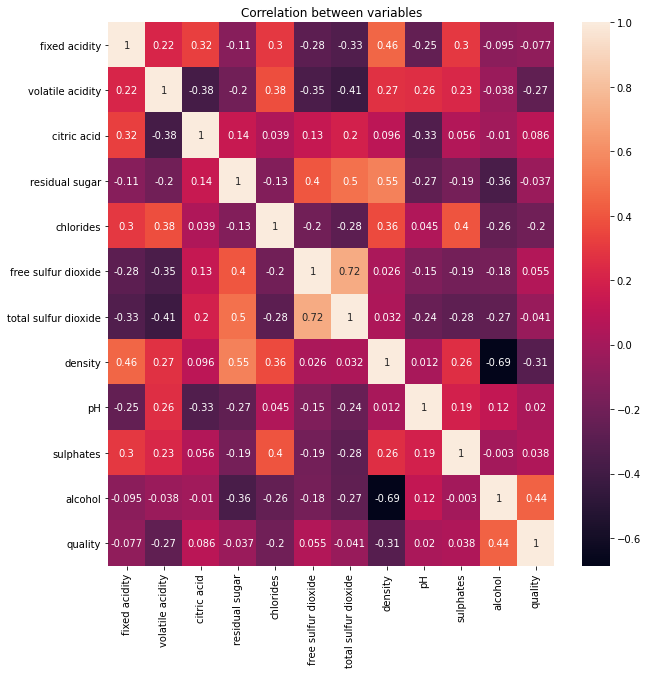

In [19]:
#Check correlation
corr = full.corr()
fig, ax = plt.subplots(figsize = (10,10))
g= sns.heatmap(corr,ax=ax, annot= True)
ax.set_title('Correlation between variables')

In [20]:
corr_vec = full.corr()['quality']
print(abs(corr_vec) > 0.05)
print((abs(corr_vec)).idxmin())

fixed acidity            True
volatile acidity         True
citric acid              True
residual sugar          False
chlorides                True
free sulfur dioxide      True
total sulfur dioxide    False
density                  True
pH                      False
sulphates               False
alcohol                  True
quality                  True
Name: quality, dtype: bool
pH


In [21]:
#Remove not needed data
red_df = red_df.drop(['residual sugar','pH','sulphates','total sulfur dioxide'], axis = 1)
white_df = white_df.drop(['residual sugar','pH','sulphates','total sulfur dioxide'], axis = 1)

In [22]:
#Scale data with MinMax Scaler
scaler = MinMaxScaler()

#this function return scaled data
def Khoi_Scaler(data):
  scaler.fit(data)
  return scaler.transform(data)

In [23]:
#Scale data with Robust Scaler
transform = RobustScaler()

#this funtion return scaled data
def Khoi_Robust(data):
  return transform.fit_transform(data)

In [24]:
#Scale data with Standard Scaler
khoi_scaler = StandardScaler()

#this function return data scaled by Standard Scaler
def Khoi_SD_Scaler(data):
  return khoi_scaler.fit_transform(data)

In [25]:
#Data partition

#This is function return train and target data set
def needed_data(data, target_label, index):
  #Scale data
  data = Khoi_Robust(data)
  # data = Khoi_SD_Scaler(data)
  # data = Khoi_Scaler(data)
  #split data
  X_train_full1, X_test_full1,Y_train_full1,Y_test_full1 = train_test_split(np.delete(data, index, axis = 1),data[:,index], test_size = 0.1, random_state = 100)
  X_train_full2, X_test_full2,Y_train_full2, Y_test_full2 = train_test_split(np.delete(data, index, axis = 1),data[:,index], test_size = 0.1, random_state = 220)
  X_train_full3, X_test_full3,Y_train_full3,Y_test_full3 = train_test_split(np.delete(data, index, axis = 1),data[:,index], test_size = 0.1, random_state = 343)
  #store data
  train_full = [X_train_full1, X_train_full2, X_train_full3]
  test_full = [X_test_full1, X_test_full2, X_test_full3]
  Y_test_full = [Y_test_full1, Y_test_full2, Y_test_full3]  
  #return data
  return [train_full, test_full, Y_test_full]

# **K mean clustering**

## **Preparation**

In [26]:
all_label_target = red_df.columns

In [27]:
#This function calculate the 
def re_cm(cnf_matrix):
  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)

  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)

  TPR[np.isnan(TPR)] = mean(TPR[np.logical_not(np.isnan(TPR))])
  FNR[np.isnan(FNR)] = mean(FNR[np.logical_not(np.isnan(FNR))])
  PPV[np.isnan(PPV)] = mean(PPV[np.logical_not(np.isnan(PPV))])

  return [ACC, TPR, FPR, FNR, PPV]

In [28]:
#This function plot the train data and centroid
def Khoi_PLOT(train_data, centers, train_labels, figure, _title):
  plt.figure(k)
  plt.title(_title)
  plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=50, cmap='viridis')
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

In [29]:
#This function plot ROC curve
def Khoi_ROC(TP, FP, index, label):
  fig = plt.figure(figsize=(100,50))
  plt.subplot(12,3, index + 1)
  plt.title(label)  
  sns.lineplot(x=FP, y=TP)

## **K mean for red wine**

### **K mean with 2 cluster**

THE CONFUSION MATRIX OF fixed acidity in 0th test: 
   0   1
0  0  87
1  2  71

The centroids of fixed acidity in 0th test: 
[[ 6.56410256e-02  5.92851593e-01  1.24410256e+01  2.92124542e-01
   4.06699937e-01 -3.95833333e-01 -5.64102564e-01]
 [ 3.95714286e-02  1.73809524e-02  1.16142857e-01  1.25000000e-01
  -2.79322467e-03  1.43147321e-01 -3.59285714e-01]]

The Accuracy is: 0.44375 
The True positive rate is: 0.4863013698630137 
The False Positive Rate is: 0.5136986301369864 
The False Negative Rate is:0.5136986301369864 
The Precision is 0.22468354430379747

The Mean Performance of fixed acidity in 0th test is: 0.434595543610196
THE CONFUSION MATRIX OF fixed acidity in 1th test: 
    0  1
0  96  2
1  60  2

The centroids of fixed acidity in 1th test: 
[[ 2.10992148e-02  2.56310428e-02  9.39685939e-02  1.37707760e-01
  -3.35969673e-03  1.55402391e-01 -3.54032834e-01]
 [ 3.73684211e-02  5.91706539e-01  1.21631579e+01  2.77255639e-01
   4.56140351e-01 -3.84868421e-01 -6.57894737e-01]]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 1th test: 
    0  1
0  77  1
1  79  3

The centroids of quality in 1th test: 
[[ 2.10413695e-01  2.13409415e-02  2.61098863e-02  9.82168331e-02
   1.37151009e-01 -2.51159258e-03  1.54489123e-01]
 [ 2.75418275e-01  2.86486486e-02  5.88861589e-01  1.23283784e+01
   3.02123552e-01  4.36423000e-01 -3.64864865e-01]]

The Accuracy is: 0.5 
The True positive rate is: 0.5118824265165729 
The False Positive Rate is: 0.4881175734834271 
The False Negative Rate is:0.4881175734834271 
The Precision is 0.6217948717948718

The Mean Performance of quality in 1th test is: 0.5274781113195748
THE CONFUSION MATRIX OF quality in 2th test: 
    0  1
0  72  2
1  85  1

The centroids of quality in 2th test: 
[[ 2.01896604e-01  3.12919343e-02  2.05697229e-02  9.85010707e-02
   1.27893341e-01 -1.43074538e-03  1.46205092e-01]
 [ 3.17042607e-01  3.68421053e-03  6.40350877e-01  1.23552632e+01
   3.01691729e-01  4.59083951e-01 -3.86513158e-01]]

The Accuracy is: 0.45625 
The True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


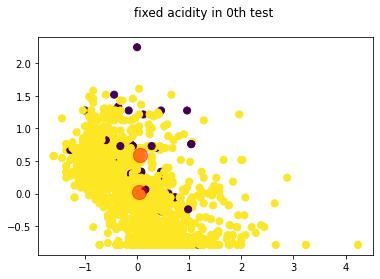

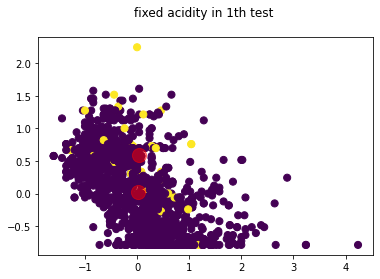

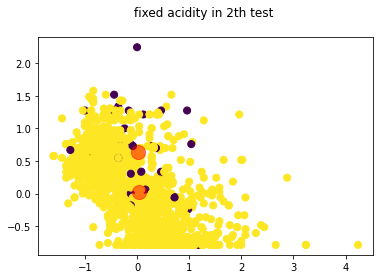

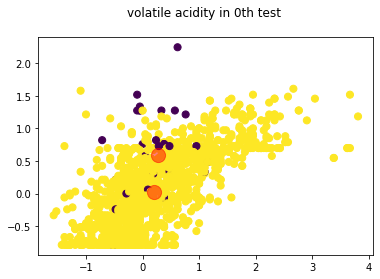

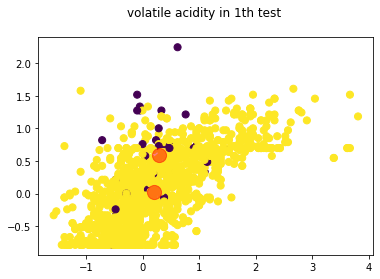

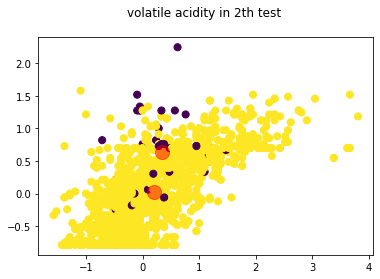

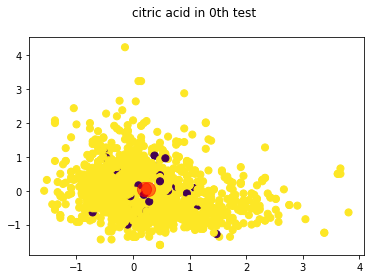

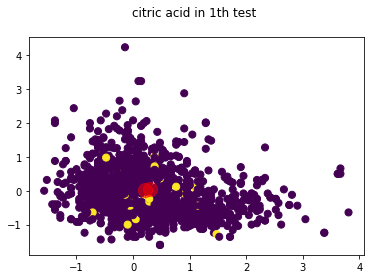

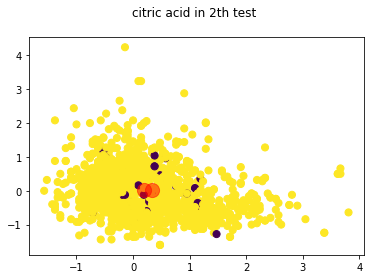

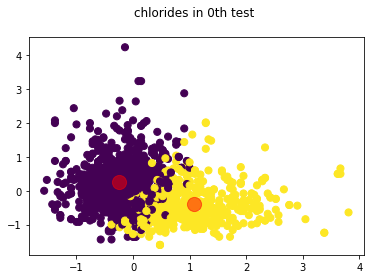

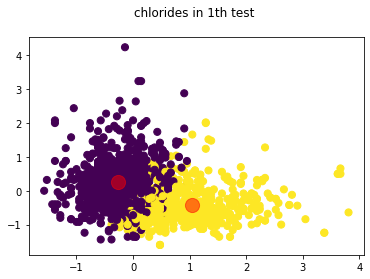

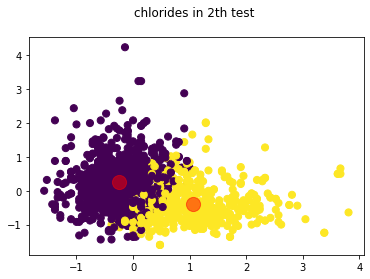

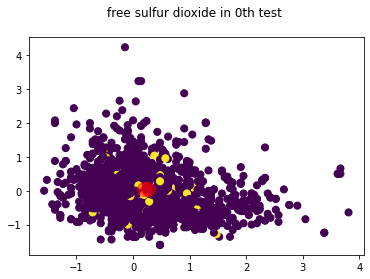

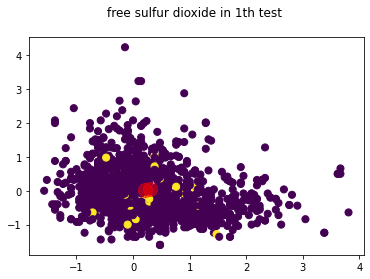

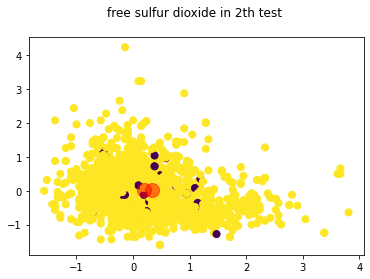

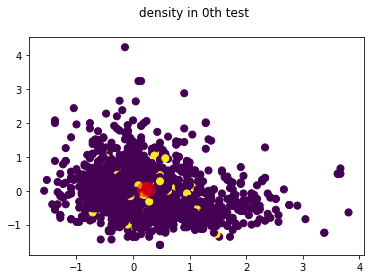

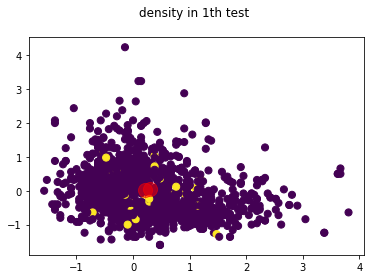

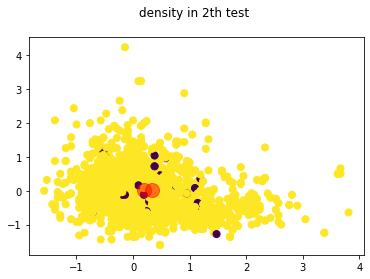

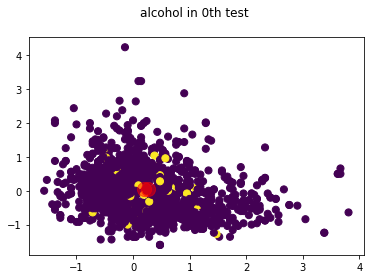

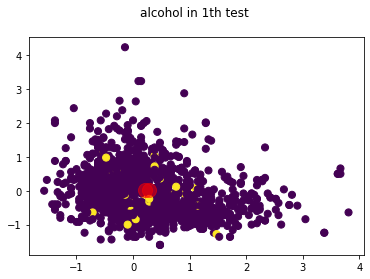

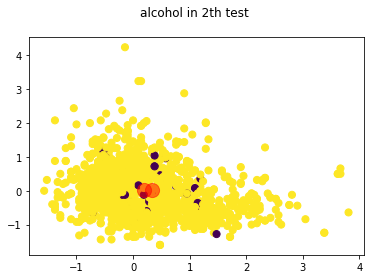

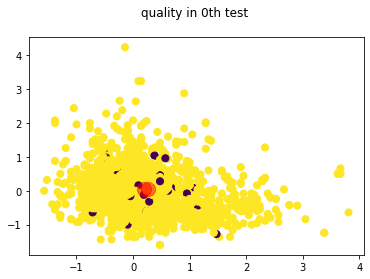

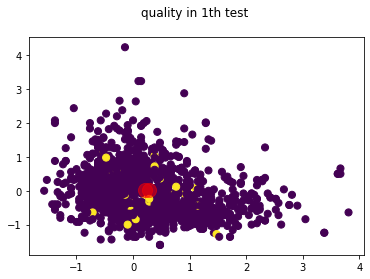

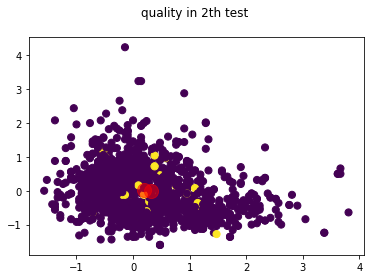

In [30]:
len_target = len(all_label_target)
k = 0
index = 0
lb_2_lst = []
TP_lst = []
FP_lst = []
while index < len_target:
  # Get needed data
  [train, test, y_actual] = needed_data(red_df, all_label_target[index], index)
  #Train
  pred = []
  centroids = []
  j = 0
  while j < len(train):
    #Train
    model_kmeans = KMeans(n_clusters=2, random_state=0).fit(train[j])
    centroids.append(model_kmeans.cluster_centers_)
    #Test
    pred.append(model_kmeans.predict(test[j]))
    #Confusion Matrix
    y_actual[j][y_actual[j] > np.mean(y_actual[j])] = 1
    y_actual[j][y_actual[j] <= np.mean(y_actual[j])] = 0
    cmatrix = confusion_matrix(y_actual[j].astype(np.int16), pred[j])
    cm_table = pd.DataFrame(cmatrix)
    cal = re_cm(cmatrix)
    print("THE CONFUSION MATRIX OF {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, cm_table))
    print("The centroids of {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, centroids[j]))
    print("The Accuracy is: {0} \nThe True positive rate is: {1} \nThe False Positive Rate is: {2} \nThe False Negative Rate is:{3} \nThe Precision is {4}\n".format(np.mean(cal[0]), np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])))
    print("The Mean Performance of {0} in {1}th test is: {2}".format(all_label_target[index], j, mean([np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])])))    
    Khoi_PLOT(train[j], centroids[j], model_kmeans.labels_, k, "{0} in {1}th test \n".format(all_label_target[index], j))
    #Store
    lb_2_lst.append("{0} in {1}th test \n".format(all_label_target[index], j))
    TP_lst.append(cal[1])
    FP_lst.append(cal[2])
    k += 1
    j += 1
  index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

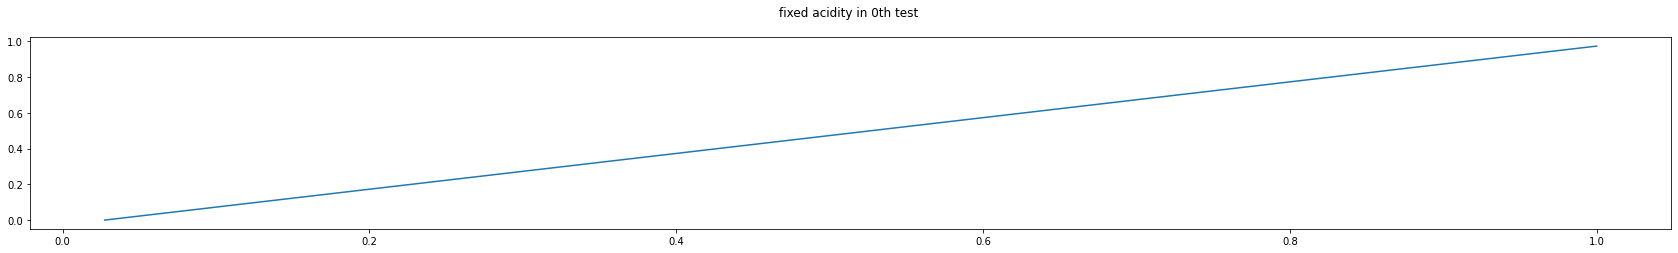

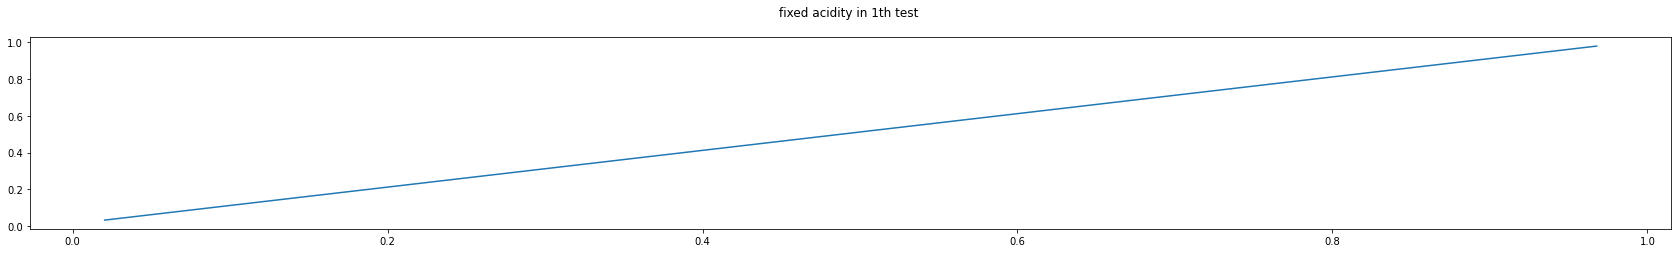

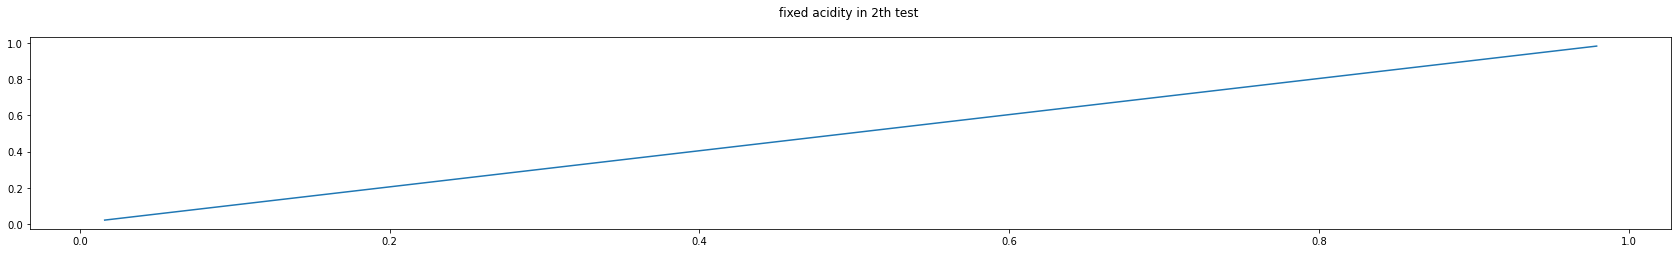

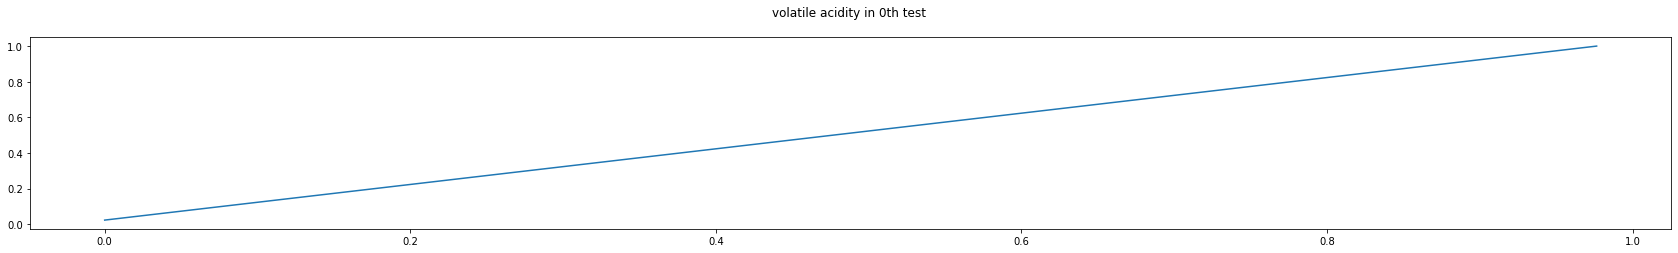

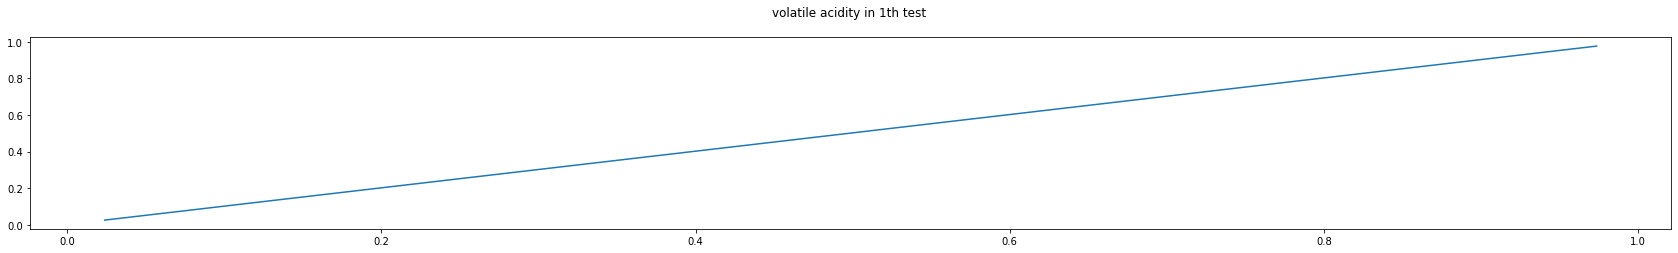

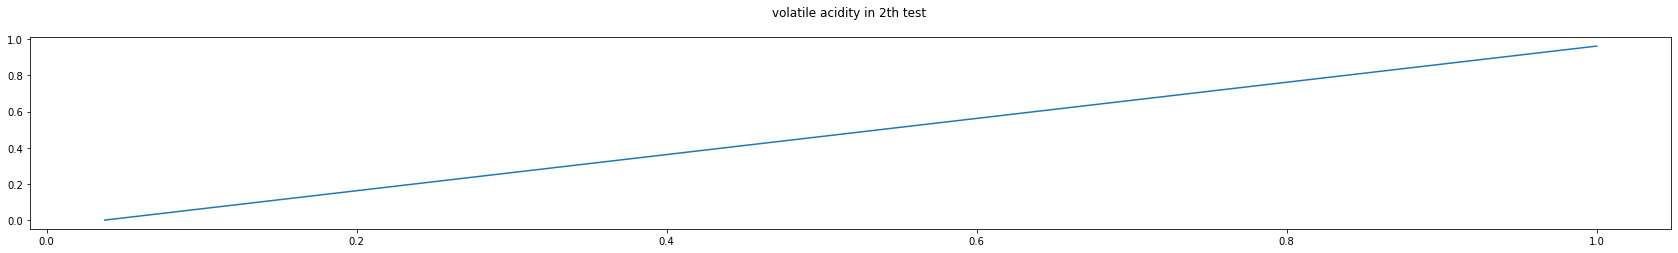

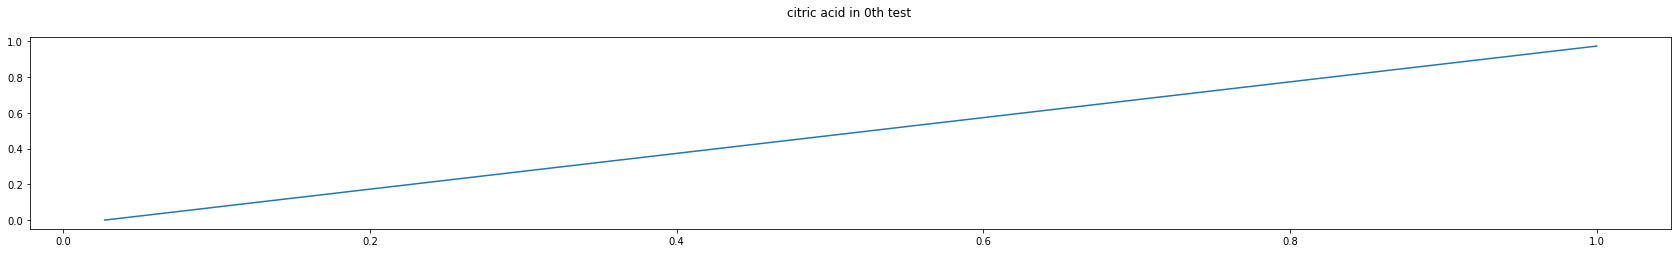

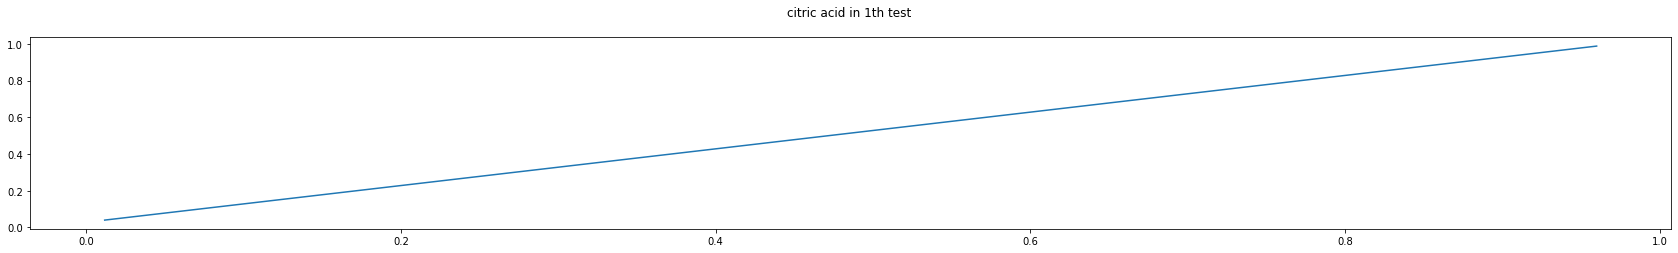

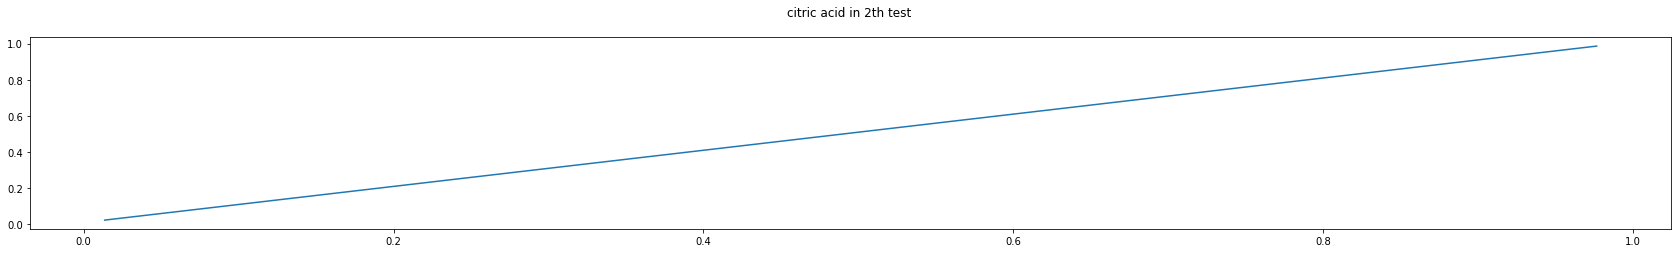

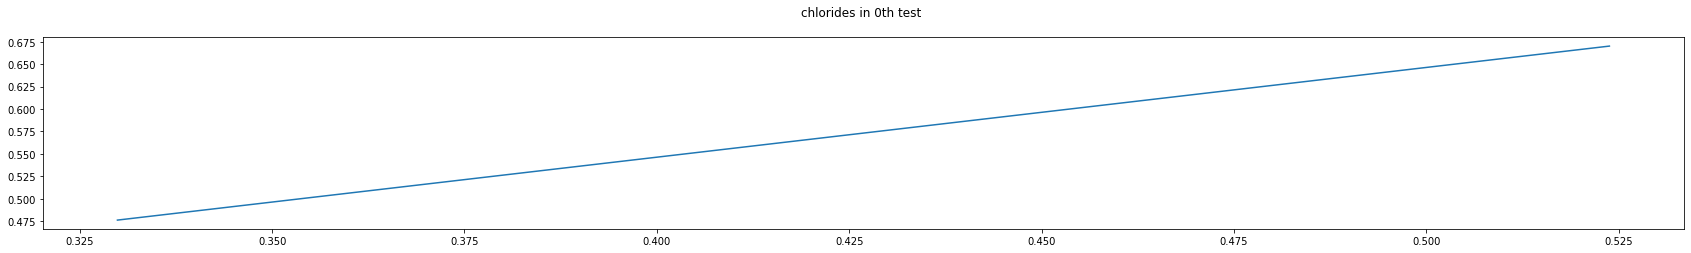

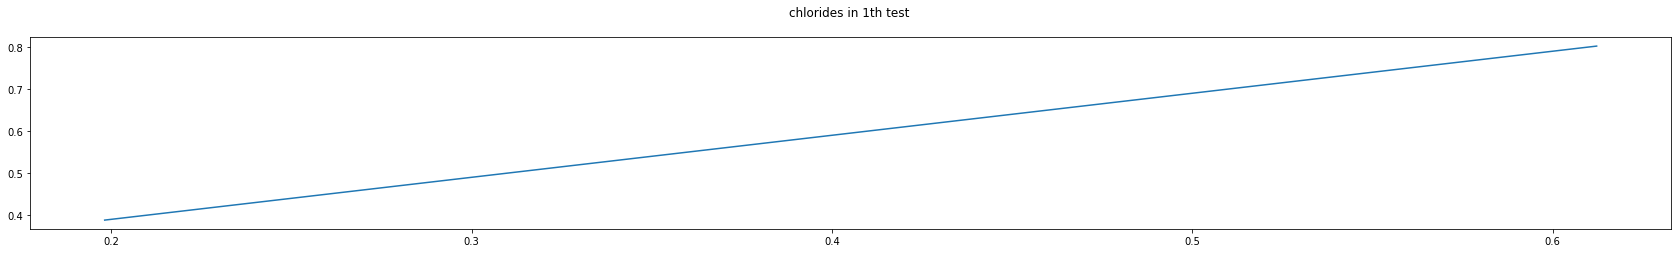

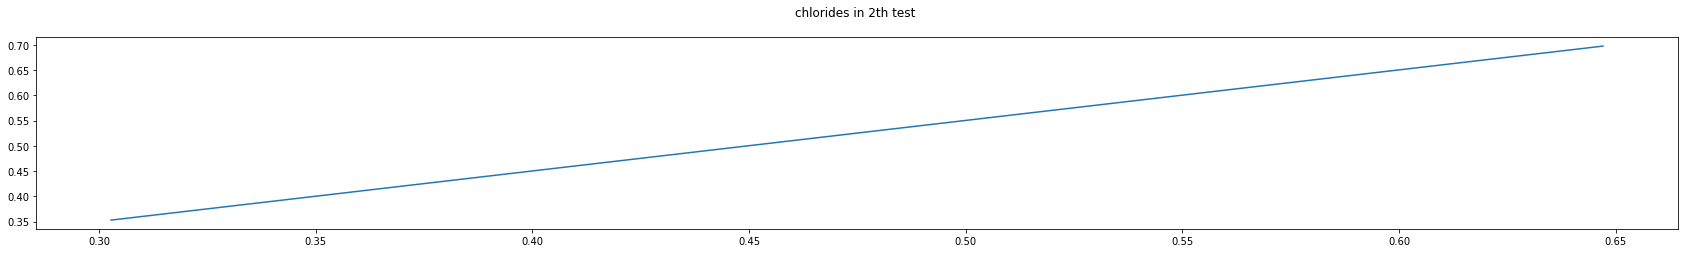

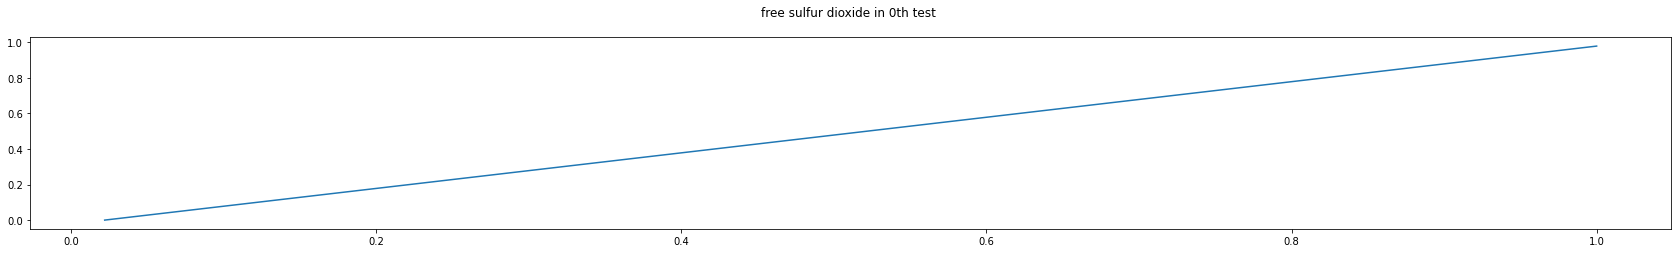

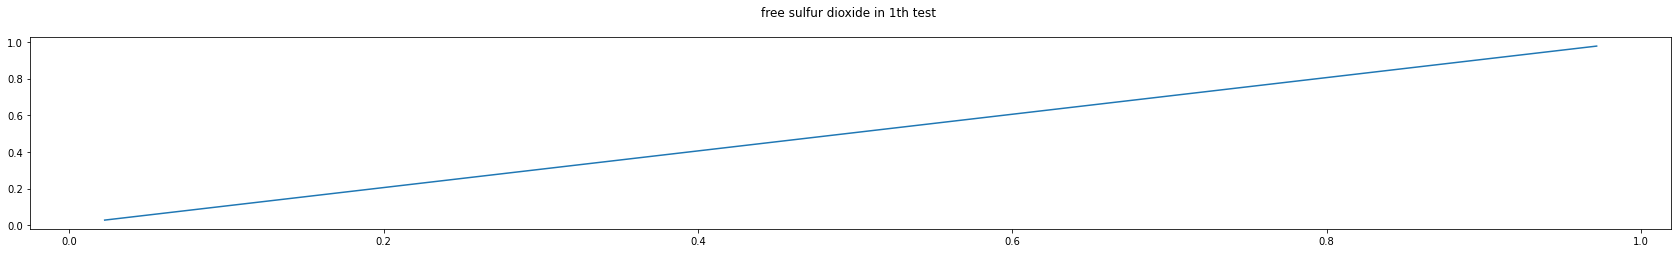

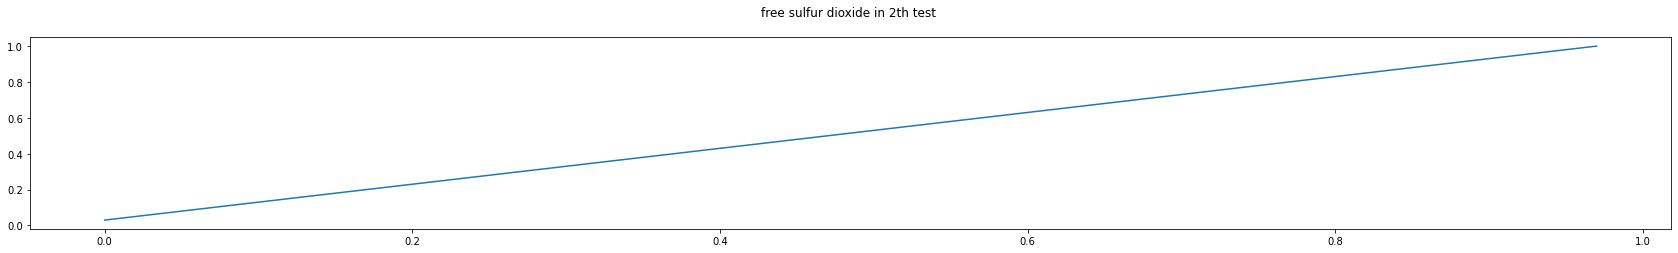

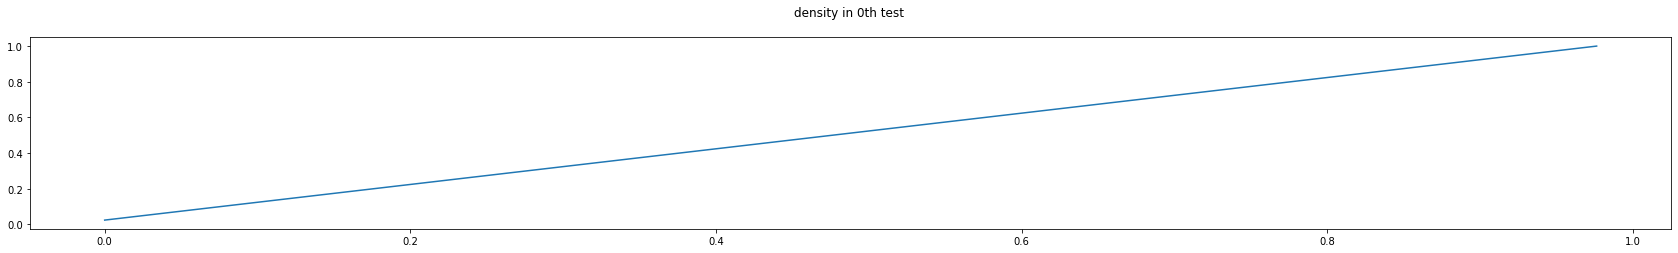

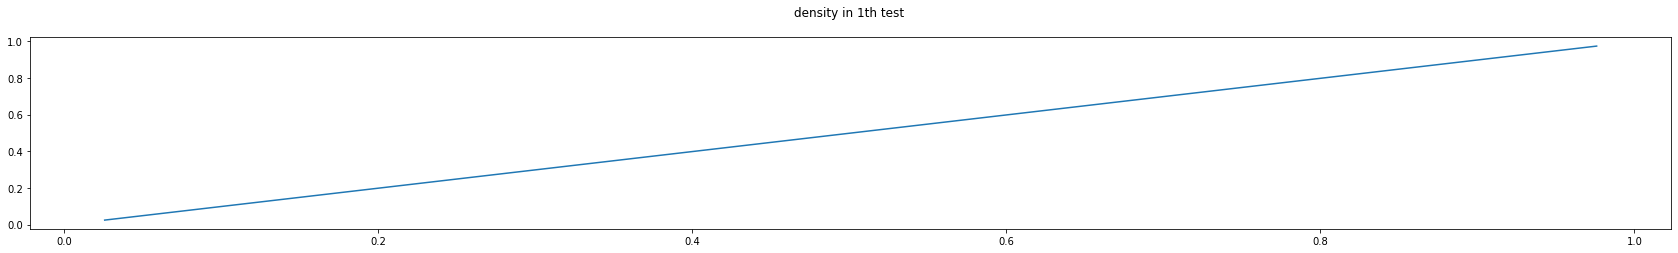

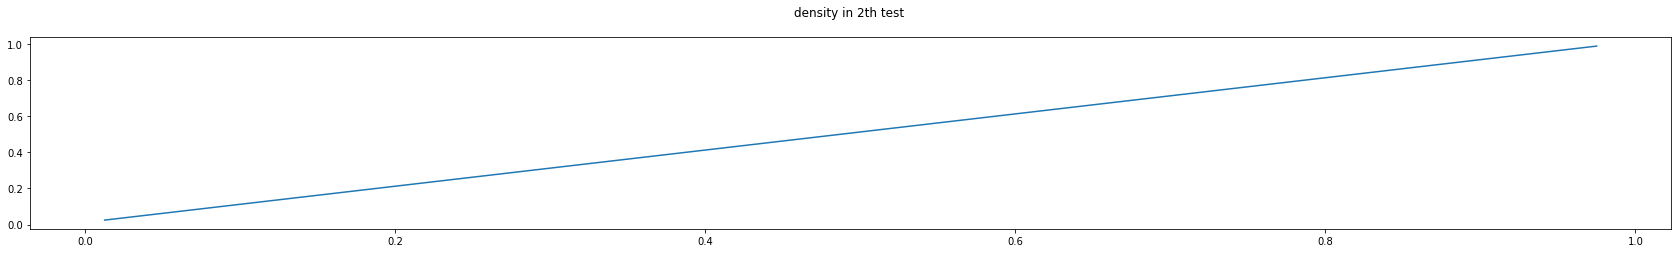

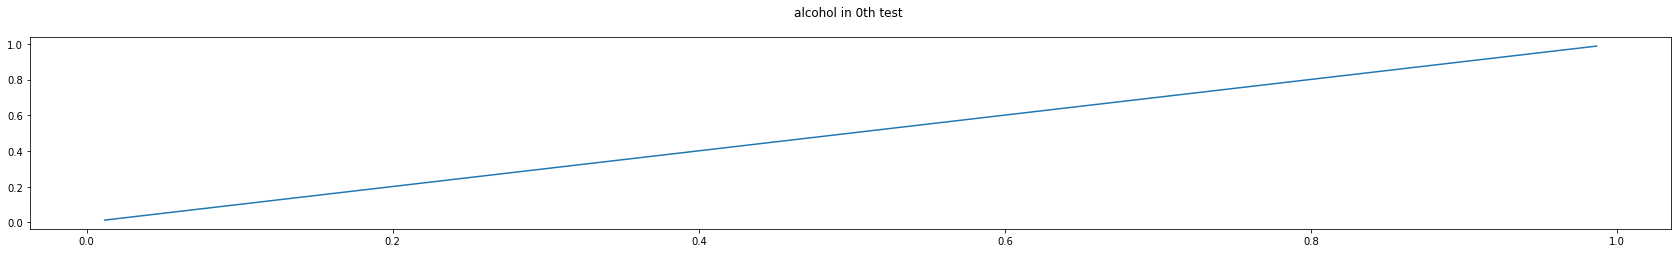

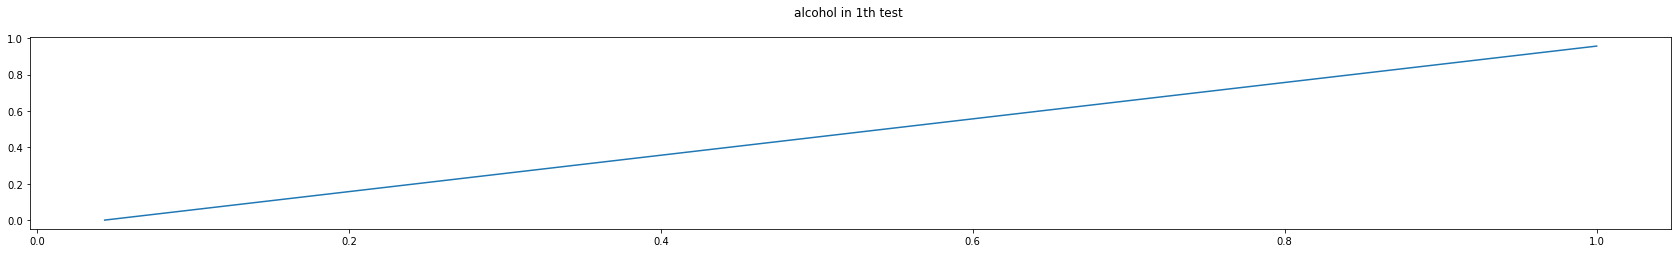

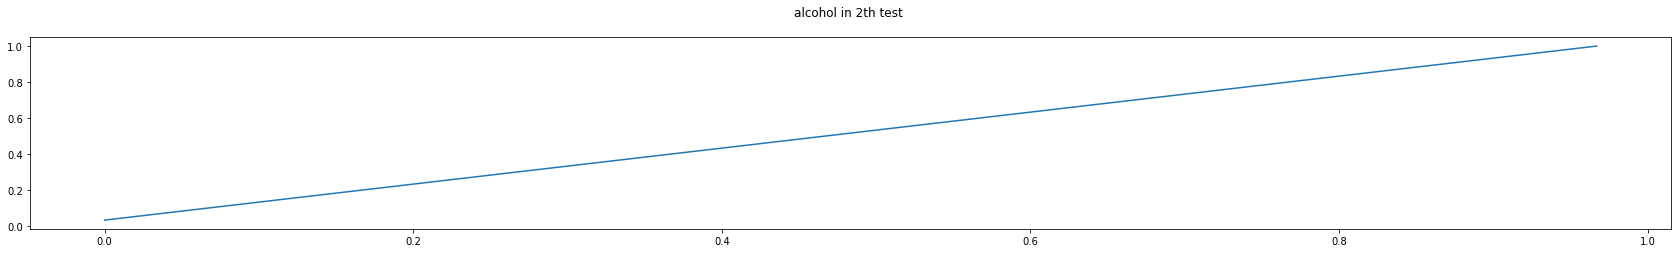

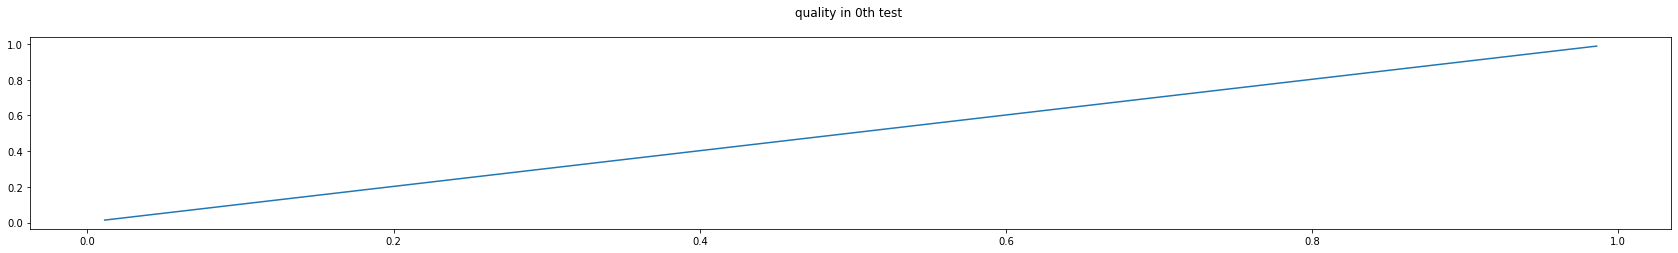

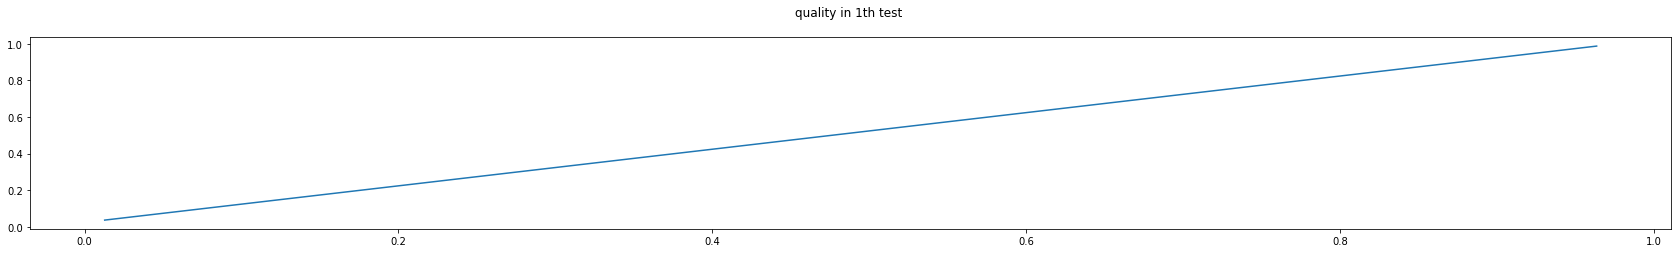

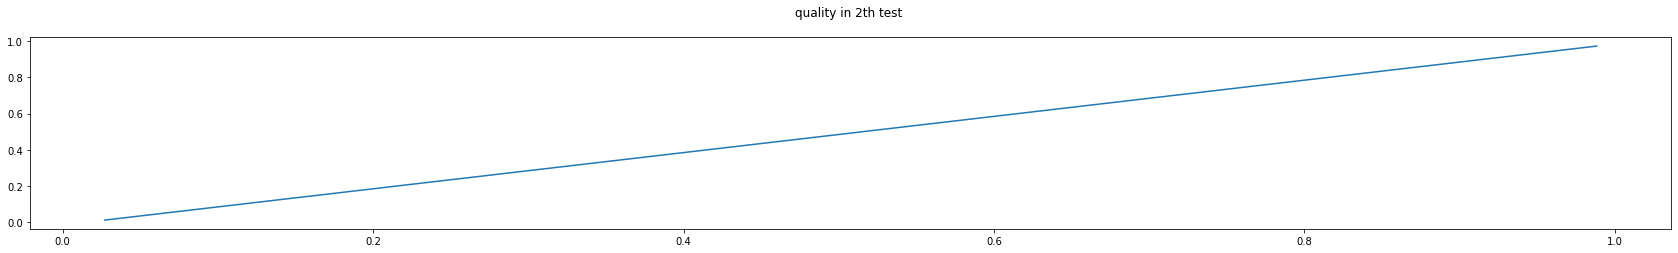

In [31]:
#ROC Curve for 2 cluster
for n in range(len(lb_2_lst)):
  Khoi_ROC(TP_lst[n], FP_lst[n], n, lb_2_lst[n])

### **K mean with 3 cluster**

THE CONFUSION MATRIX OF fixed acidity in 0th test: 
    0  1   2
0  84  2  59
1  13  0   1
2   1  0   0

The centroids of fixed acidity in 0th test: 
[[ 2.15658043e-01 -9.74878140e-03  5.26940382e-01  1.25582516e-01
   3.55244185e-01 -1.87804649e-01 -7.03037120e-01]
 [ 1.31250000e-01  6.06060606e-01  1.37125000e+01  7.92410714e-02
   1.13255034e-01 -3.98437500e-01 -6.56250000e-01]
 [-2.66332046e-01  7.09020709e-02 -5.00868726e-01  1.39409818e-01
  -5.93601271e-01  7.04009813e-01  2.33590734e-01]]

The Accuracy is: 0.6833333333333332 
The True positive rate is: 0.1931034482758621 
The False Positive Rate is: 0.4414634846787859 
The False Negative Rate is:0.8068965517241379 
The Precision is 0.2857142857142857

The Mean Performance of fixed acidity in 0th test is: 0.4317944425982679
THE CONFUSION MATRIX OF fixed acidity in 1th test: 
    0  1   2
0  97  3  49
1   9  0   2
2   0  0   0

The centroids of fixed acidity in 1th test: 
[[ 0.19493923  0.01359451  0.50220994  0.13528019  0.36747

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF fixed acidity in 2th test: 
    0   1  2
0  56  85  3
1   5  11  0
2   0   0  0

The centroids of fixed acidity in 2th test: 
[[-2.88953975e-01  5.99721060e-02 -5.55230126e-01  1.55932457e-01
  -6.72133142e-01  7.45074965e-01  2.51046025e-01]
 [ 1.93892473e-01  4.17073965e-03  4.83655914e-01  1.22043011e-01
   3.56464843e-01 -1.65591398e-01 -6.70967742e-01]
 [ 5.74193548e-02  6.64711632e-01  1.36483871e+01  8.41013825e-02
   1.68001732e-01 -3.87096774e-01 -6.45161290e-01]]

The Accuracy is: 0.6124999999999999 
The True positive rate is: 0.5381944444444444 
The False Positive Rate is: 0.30717592592592596 
The False Negative Rate is:0.4618055555555556 
The Precision is 0.3442053734061931

The Mean Performance of fixed acidity in 2th test is: 0.41284532483302977
THE CONFUSION MATRIX OF volatile acidity in 0th test: 
    0   1  2
0  52  98  2
1   0   8  0
2   0   0  0

The centroids of volatile acidity in 0th test: 
[[ 0.91152437  0.37696492  1.03412229  0.0633277  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF volatile acidity in 1th test: 
    0  1   2
0  90  3  56
1   8  0   3
2   0  0   0

The centroids of volatile acidity in 1th test: 
[[-2.06082881e-01 -1.76665989e-01 -2.84060403e-01  1.99344839e-01
  -4.09856413e-01  2.44884881e-01 -3.22147651e-01]
 [ 1.41156463e-01  6.58008658e-01  1.40946429e+01  1.26275510e-01
   8.69287312e-02 -3.32589286e-01 -7.50000000e-01]
 [ 9.39025513e-01  3.82802884e-01  8.76499033e-01  4.20005526e-02
   7.28441058e-01 -1.26128304e-02 -4.10058027e-01]]

The Accuracy is: 0.7083333333333334 
The True positive rate is: 0.30201342281879195 
The False Positive Rate is: 0.37205231848688225 
The False Negative Rate is:0.697986577181208 
The Precision is 0.30612244897959184

The Mean Performance of volatile acidity in 1th test is: 0.41954369186661855
THE CONFUSION MATRIX OF volatile acidity in 2th test: 
    0   1  2
0  96  51  3
1   7   3  0
2   0   0  0

The centroids of volatile acidity in 2th test: 
[[-2.33914318e-01 -1.99509347e-01 -2.815

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF citric acid in 0th test: 
    0   1  2
0  40  95  1
1  19   4  1
2   0   0  0

The centroids of citric acid in 0th test: 
[[ 0.74209788  0.14956672  0.99419411  0.04202773  0.64224039 -0.09643992
  -0.54592721]
 [-0.17070122 -0.03591885 -0.36193317  0.19135697 -0.4309451   0.30062898
  -0.22792363]
 [ 0.22420635  0.07333333 15.72708333  0.07440476  0.10458613 -0.47135417
  -0.79166667]]

The Accuracy is: 0.5166666666666667 
The True positive rate is: 0.23039215686274508 
The False Positive Rate is: 0.5008986928104575 
The False Negative Rate is:0.7696078431372549 
The Precision is 0.2394567140329852

The Mean Performance of citric acid in 0th test is: 0.4350888517108607
THE CONFUSION MATRIX OF citric acid in 1th test: 
    0  1   2
0  46  1  94
1   4  2  13
2   0  0   0

The centroids of citric acid in 1th test: 
[[-0.14391731 -0.2180705  -0.51391466  0.18592632 -0.67139827  0.64005489
   0.12059369]
 [ 0.15821813  0.07548387 13.43548387  0.05414747  0.16439345 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF citric acid in 2th test: 
    0   1  2
0  64  79  3
1   3  10  0
2   0   1  0

The centroids of citric acid in 2th test: 
[[-0.18212197 -0.21699805 -0.53157895  0.18386243 -0.70651648  0.65464587
   0.14230019]
 [ 0.42734906  0.17120536  0.51813616  0.10395408  0.41655681 -0.14969308
  -0.64397321]
 [ 0.18095238  0.06333333 13.865       0.10595238  0.15495899 -0.38541667
  -0.66666667]]

The Accuracy is: 0.6416666666666666 
The True positive rate is: 0.4025289778714436 
The False Positive Rate is: 0.25912377529628206 
The False Negative Rate is:0.5974710221285564 
The Precision is 0.355444997236042

The Mean Performance of citric acid in 2th test is: 0.40364219313308103
THE CONFUSION MATRIX OF chlorides in 0th test: 
    0   1   2
0  34  74  50
1   1   0   0
2   0   1   0

The centroids of chlorides in 0th test: 
[[ 1.34040404 -0.4149697   0.70486685 -0.07034632  0.85641651  0.14880051
  -0.0969697 ]
 [-0.07727596  0.39424695 -0.22893795  0.16752278  0.07382247 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF density in 1th test: 
    0  1    2
0  38  4  116
1   2  0    0
2   0  0    0

The centroids of density in 1th test: 
[[ 0.84897429 -0.56163743  0.56382539 -0.04873294 -0.02659426  0.50881254
   0.18908382]
 [ 0.27541828  0.02864865  0.58886159 12.32837838  0.30212355 -0.36486486
  -0.59459459]
 [-0.15806953  0.35775028 -0.28418039  0.18301462  0.23164069 -0.04997422
  -0.6704162 ]]

The Accuracy is: 0.4916666666666667 
The True positive rate is: 0.12025316455696204 
The False Positive Rate is: 0.5834388185654008 
The False Negative Rate is:0.8797468354430379 
The Precision is 0.31666666666666665

The Mean Performance of density in 1th test is: 0.47502637130801684
THE CONFUSION MATRIX OF density in 2th test: 
   0   1   2
0  3  99  55
1  0   0   3
2  0   0   0

The centroids of density in 2th test: 
[[ 3.17042607e-01  3.68421053e-03  6.40350877e-01  1.23552632e+01
   3.01691729e-01 -3.86513158e-01 -5.52631579e-01]
 [-1.55037539e-01  3.58302095e-01 -2.80946176e-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF alcohol in 0th test: 
    0   1  2
0  48  92  2
1   1  16  0
2   0   1  0

The centroids of alcohol in 0th test: 
[[ 1.04199941 -0.17817805  0.49011858  0.83571429  0.04229518  0.7251657
  -0.2505176 ]
 [-0.2328556   0.15225458 -0.22490275 -0.18640777  0.17429496 -0.36598298
  -0.41316073]
 [ 0.10673235  0.09931034  0.66248694 14.37758621  0.15147783  0.03317133
  -0.72413793]]

The Accuracy is: 0.6 
The True positive rate is: 0.4264015465341066 
The False Positive Rate is: 0.23949460741913572 
The False Negative Rate is:0.5735984534658934 
The Precision is 0.37546027585346065

The Mean Performance of alcohol in 0th test is: 0.4037387208181491
THE CONFUSION MATRIX OF alcohol in 1th test: 
    0  1   2
0  86  3  47
1  18  0   5
2   1  0   0

The centroids of alcohol in 1th test: 
[[-2.31756339e-01  1.59740260e-01 -2.27633478e-01 -1.85064935e-01
   2.16141002e-01 -3.59656004e-01 -4.19913420e-01]
 [ 1.58218126e-01  7.54838710e-02  6.00195503e-01  1.34354839e+01
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  Thi

THE CONFUSION MATRIX OF quality in 1th test: 
    0  1   2
0  98  3  58
1   1  0   0
2   0  0   0

The centroids of quality in 1th test: 
[[-0.23237885  0.120837   -0.21228808 -0.21310573  0.20382316 -0.39588446
   0.21570989]
 [ 0.15821813  0.07548387  0.6001955  13.43548387  0.05414747  0.16439345
  -0.36290323]
 [ 1.02257143 -0.16216     0.46509091  0.7417      0.03342857  0.73398658
   0.03695833]]

The Accuracy is: 0.7416666666666666 
The True positive rate is: 0.3081761006289308 
The False Positive Rate is: 0.4604559748427673 
The False Negative Rate is:0.6918238993710691 
The Precision is 0.32996632996632996

The Mean Performance of quality in 1th test is: 0.4476055762022743
THE CONFUSION MATRIX OF quality in 2th test: 
    0  1   2
0  44  3  94
1   7  0  12
2   0  0   0

The centroids of quality in 2th test: 
[[ 9.43935310e-01 -9.92452830e-02  4.15837621e-01  8.21132075e-01
   6.14555256e-02  7.28994133e-01 -1.08883648e-02]
 [ 1.66666667e-01  1.64285714e-02  7.29437229e-01  1.4

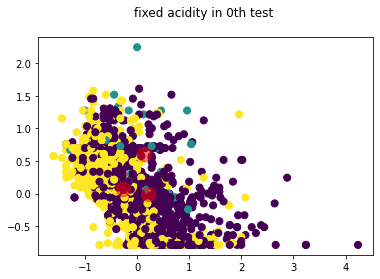

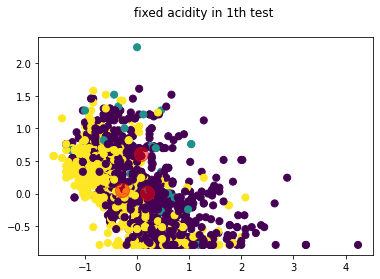

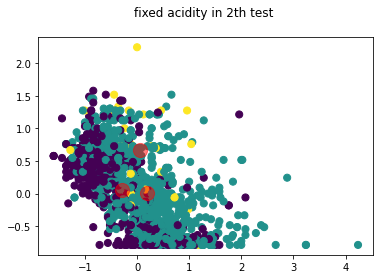

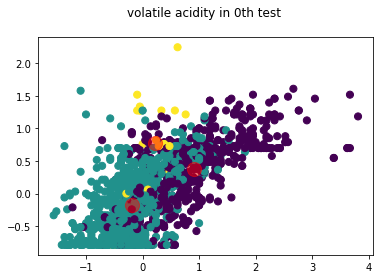

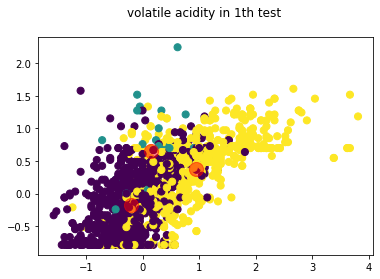

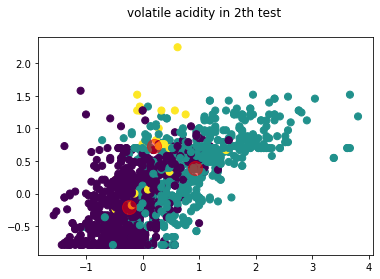

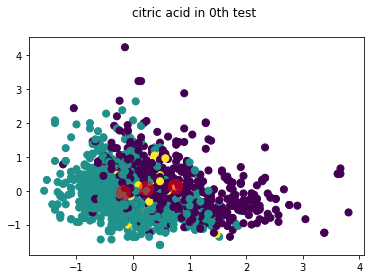

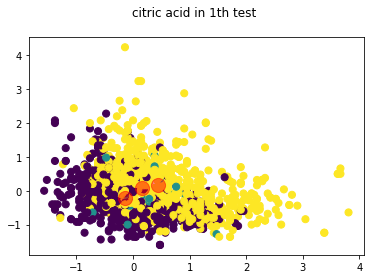

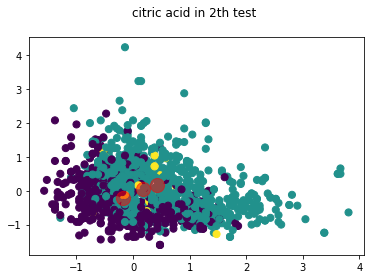

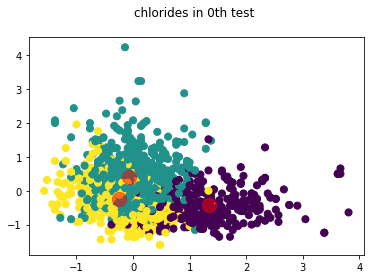

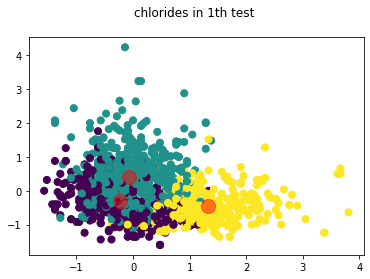

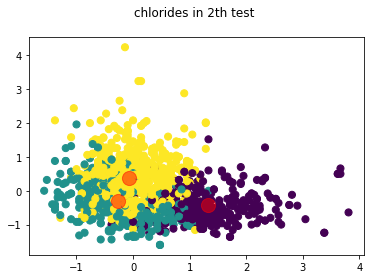

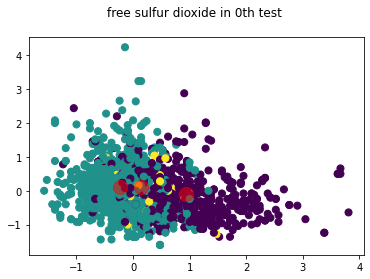

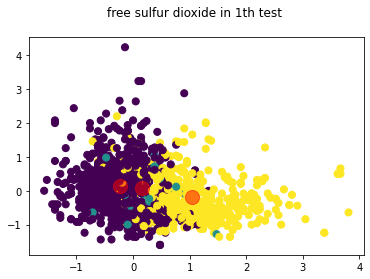

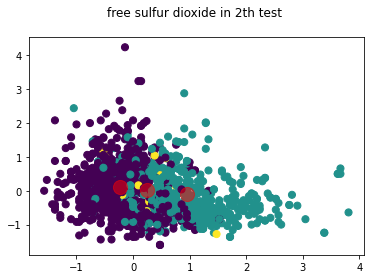

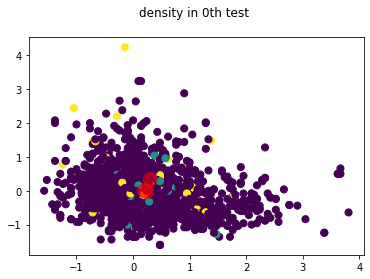

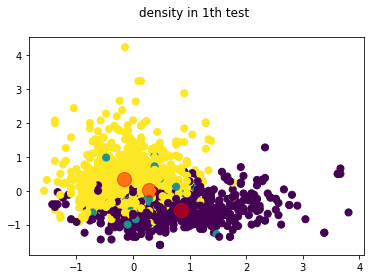

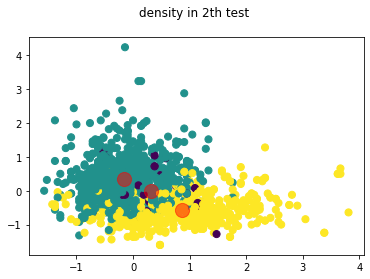

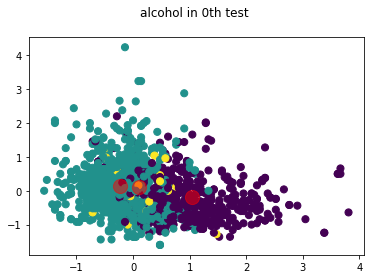

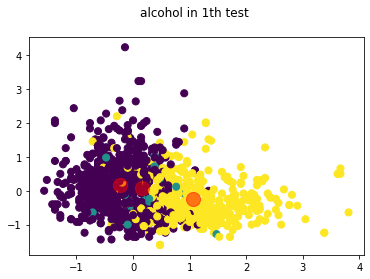

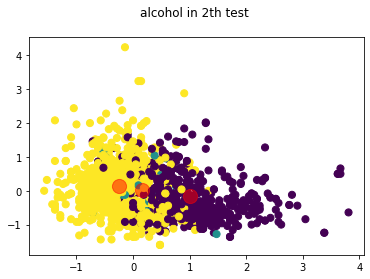

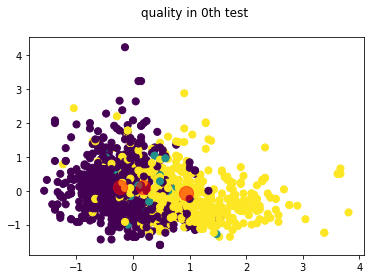

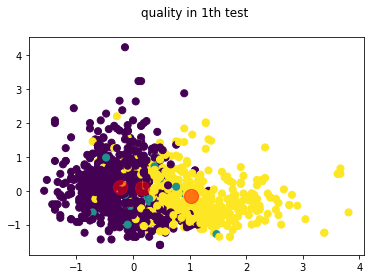

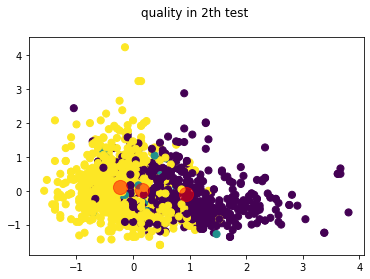

In [32]:
len_target = len(all_label_target)
k = 0
index = 0
lb_3_lst = []
TP_lst_3 = []
FP_lst_3 = []
while index < len_target:
  # Get needed data
  [train, test, y_actual] = needed_data(red_df, all_label_target[index], index)
  #Train
  pred = []
  centroids = []
  j = 0
  while j < len(train):
    #Train
    model_kmeans = KMeans(n_clusters=3, random_state=0).fit(train[j])
    centroids.append(model_kmeans.cluster_centers_)
    #Test
    pred.append(model_kmeans.predict(test[j]))
    #Confusion Matrix
    dis = np.amax(y_actual[j]) - np.amin(y_actual[j])
    y_actual[j][y_actual[j] < (dis/3)] = 0
    y_actual[j][(y_actual[j] >= (dis/3)) & (y_actual[j] < (dis/3)*2)] = 1
    y_actual[j][y_actual[j] >= (dis/3)*2] = 2
    cmatrix = confusion_matrix(y_actual[j].astype(np.int16), pred[j])
    cm_table = pd.DataFrame(cmatrix)
    cal = re_cm(cmatrix)
    print("THE CONFUSION MATRIX OF {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, cm_table))
    print("The centroids of {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, centroids[j]))
    print("The Accuracy is: {0} \nThe True positive rate is: {1} \nThe False Positive Rate is: {2} \nThe False Negative Rate is:{3} \nThe Precision is {4}\n".format(np.mean(cal[0]), np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])))
    print("The Mean Performance of {0} in {1}th test is: {2}".format(all_label_target[index], j, mean([np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])])))    
    Khoi_PLOT(train[j], centroids[j], model_kmeans.labels_, k, "{0} in {1}th test \n".format(all_label_target[index], j))
    #Store
    lb_3_lst.append("{0} in {1}th test \n".format(all_label_target[index], j))
    TP_lst_3.append(cal[1])
    FP_lst_3.append(cal[2])
    k += 1
    j += 1
  index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

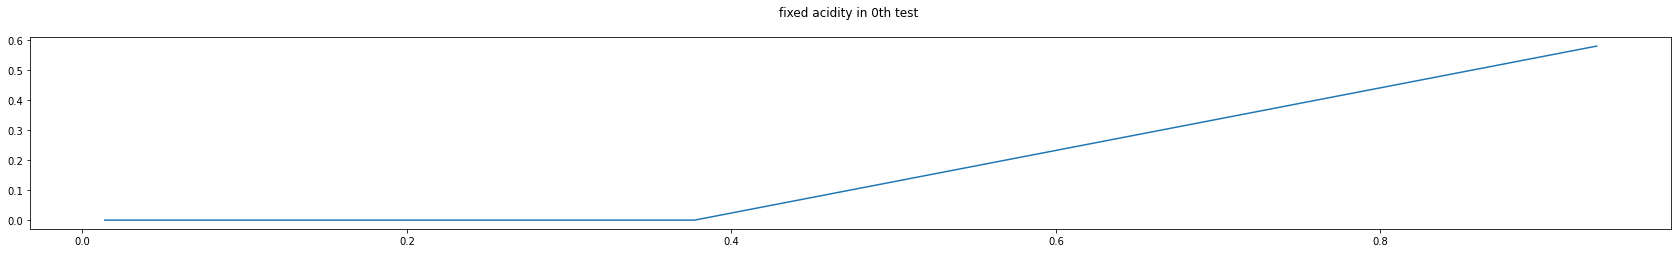

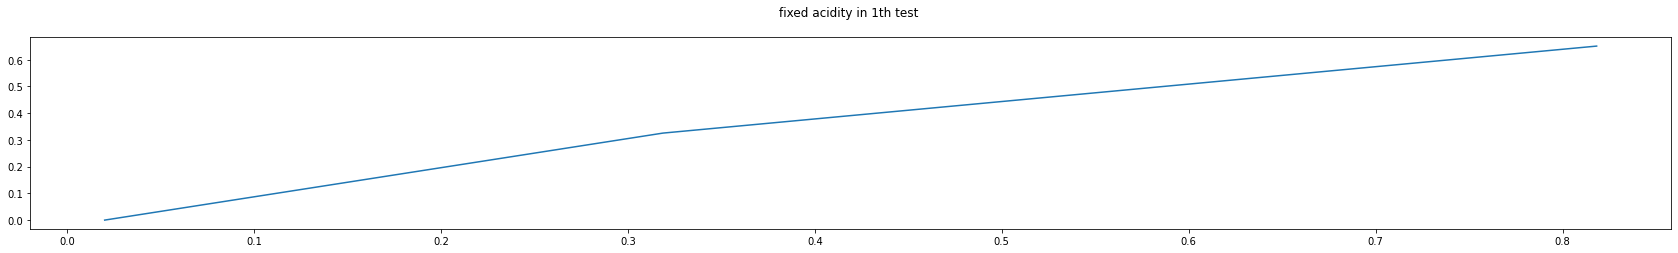

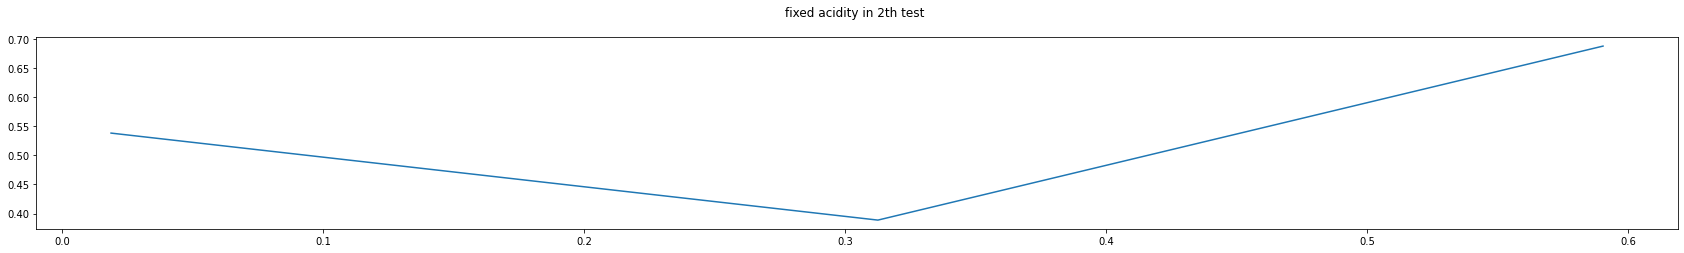

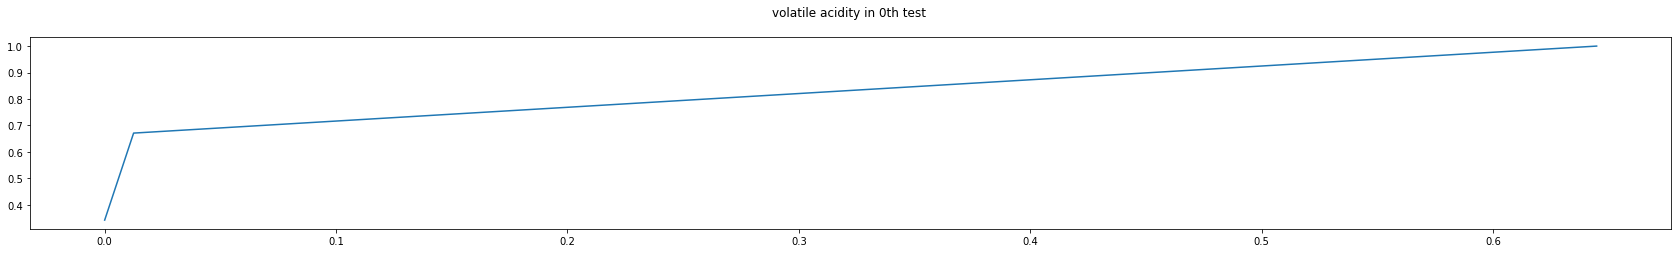

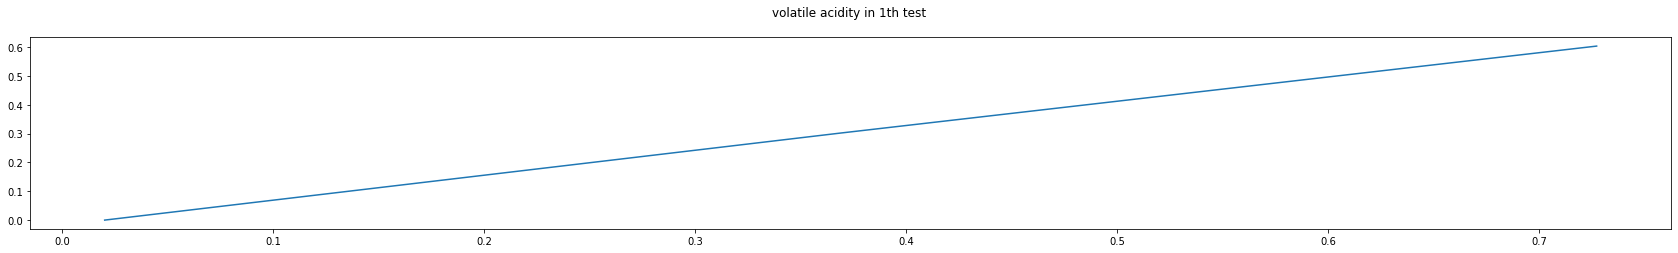

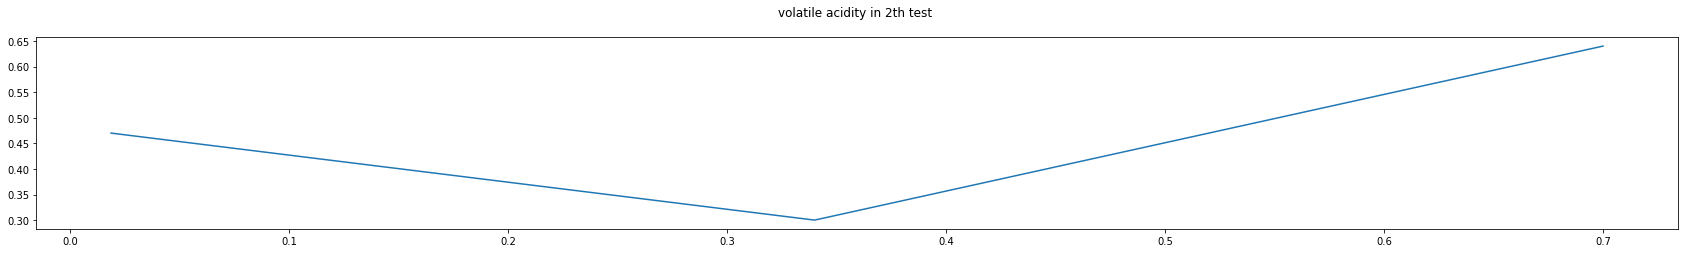

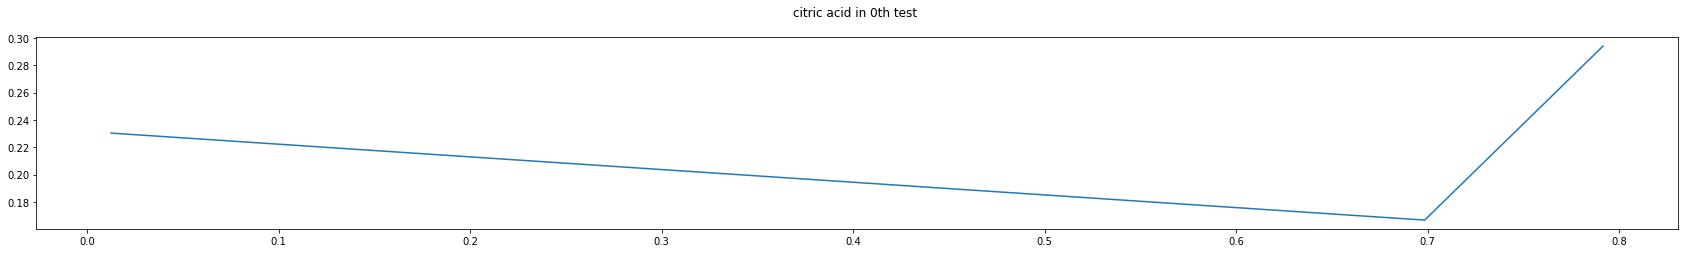

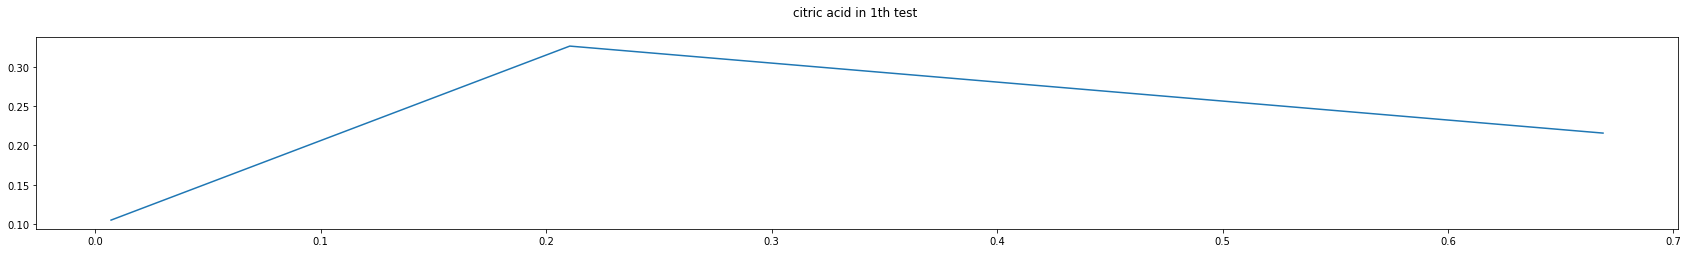

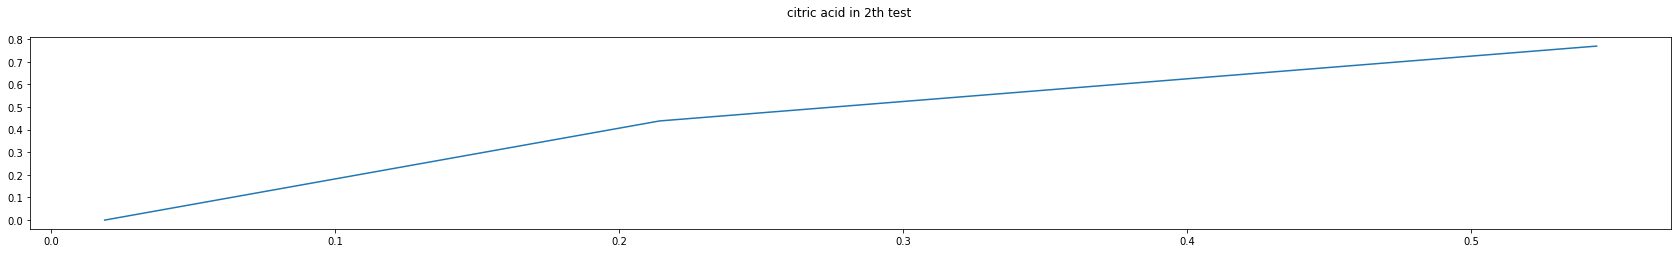

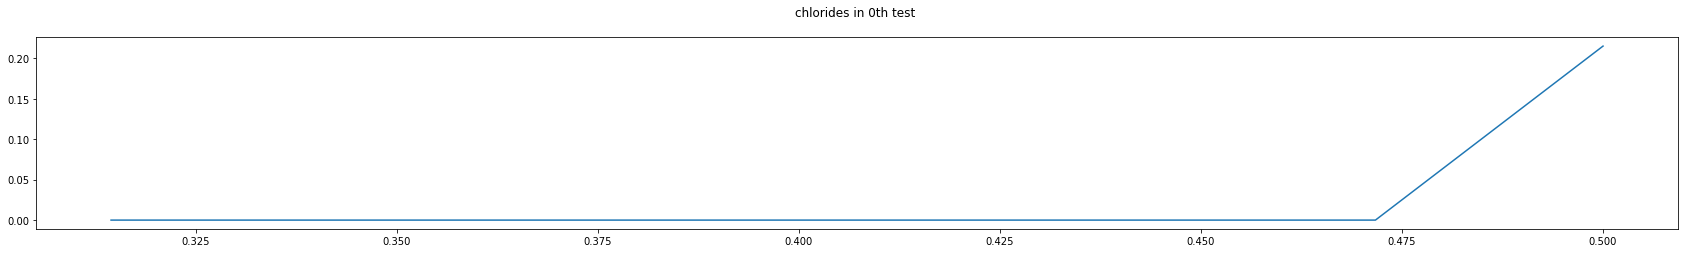

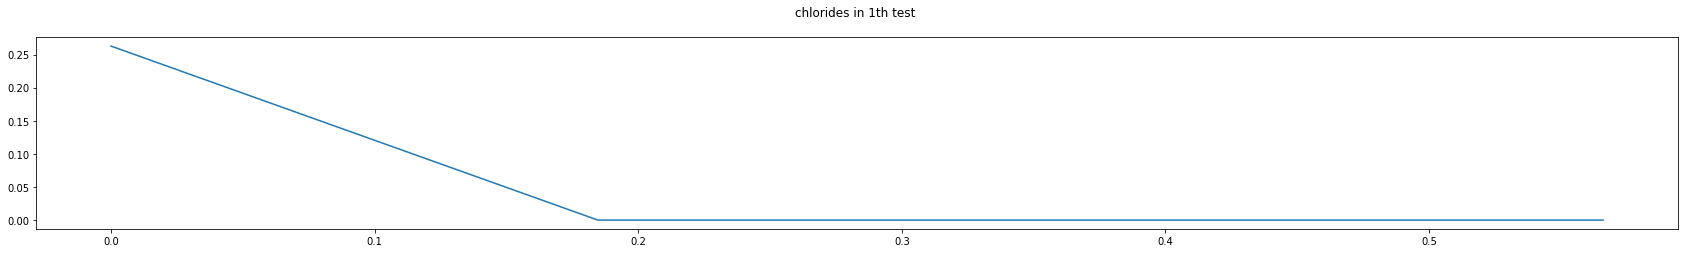

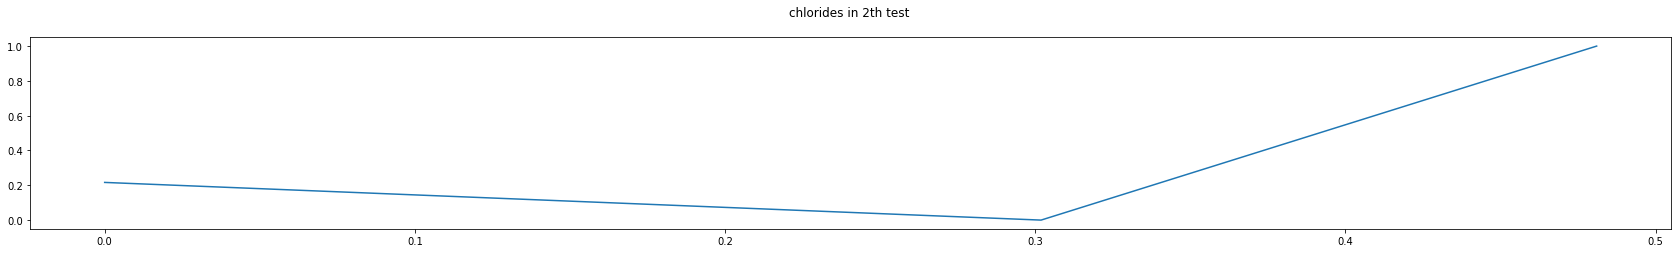

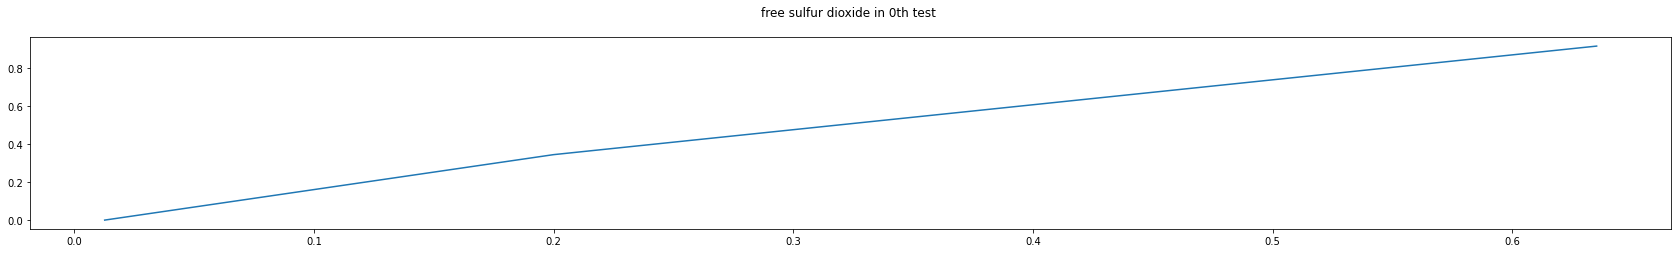

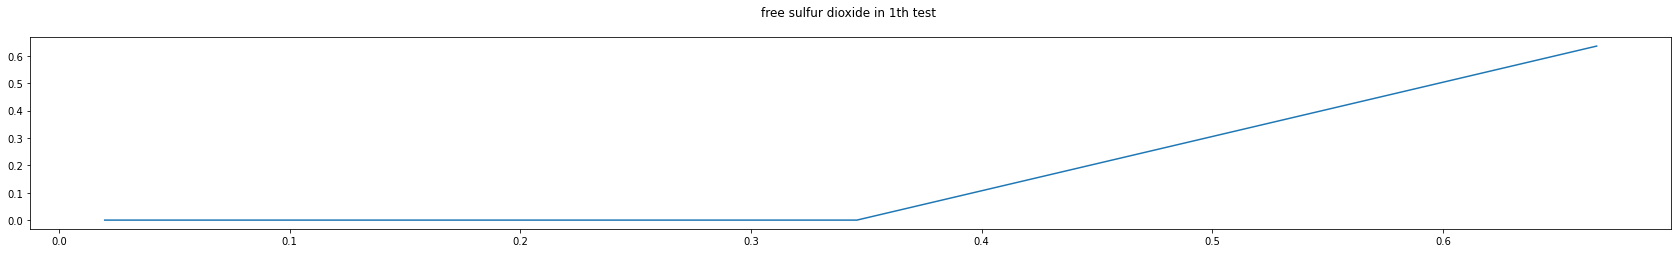

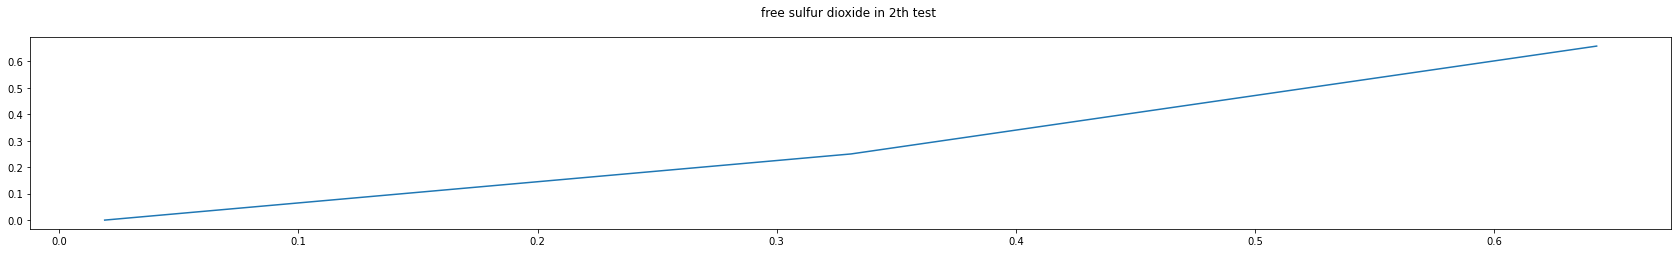

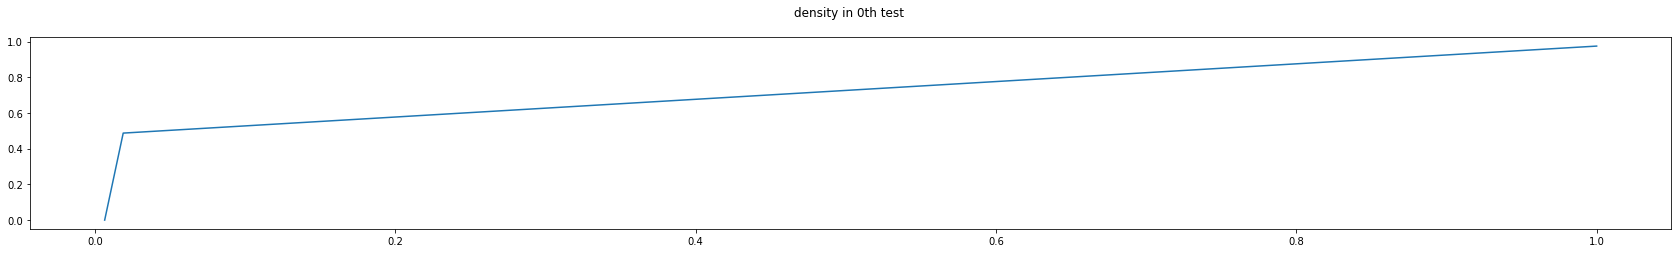

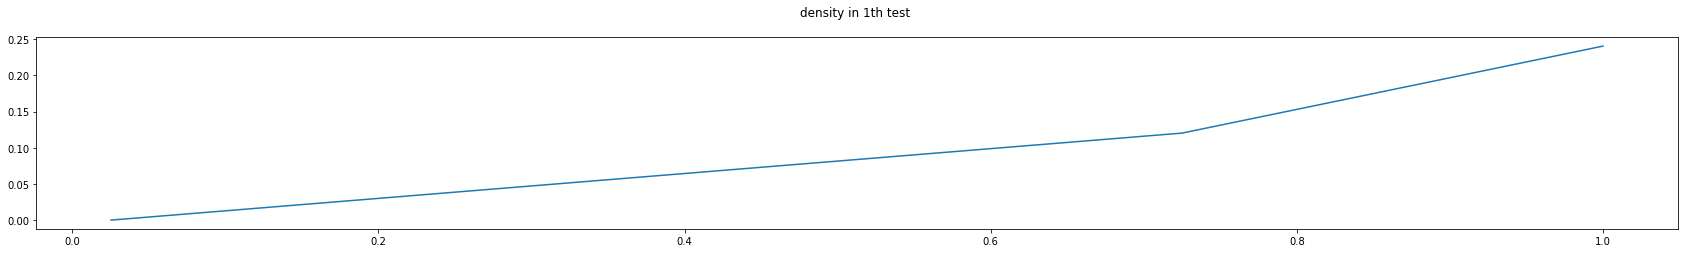

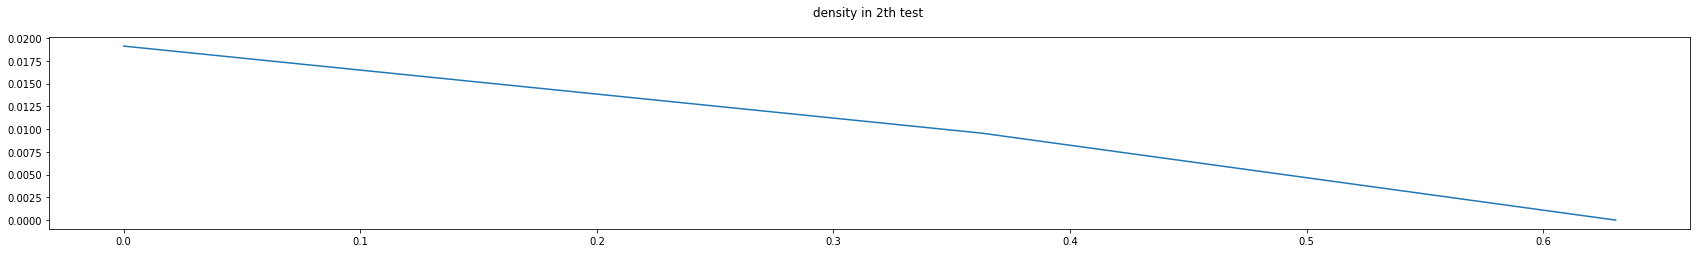

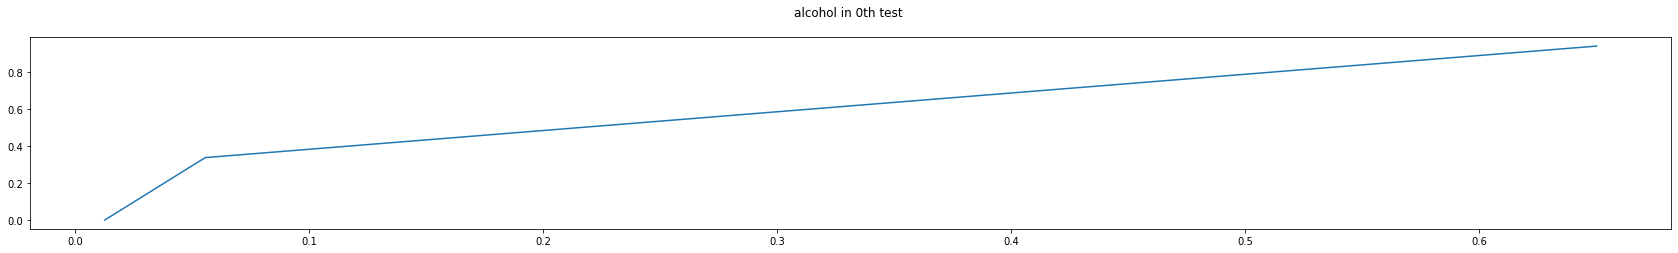

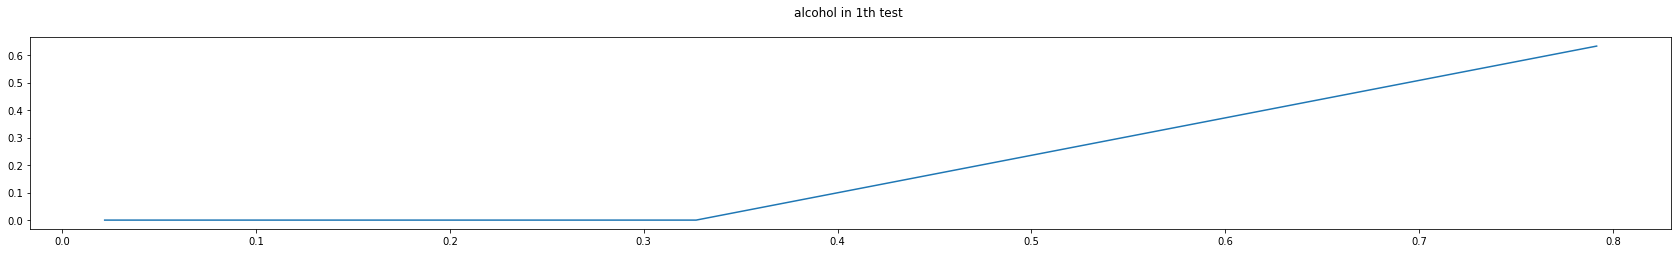

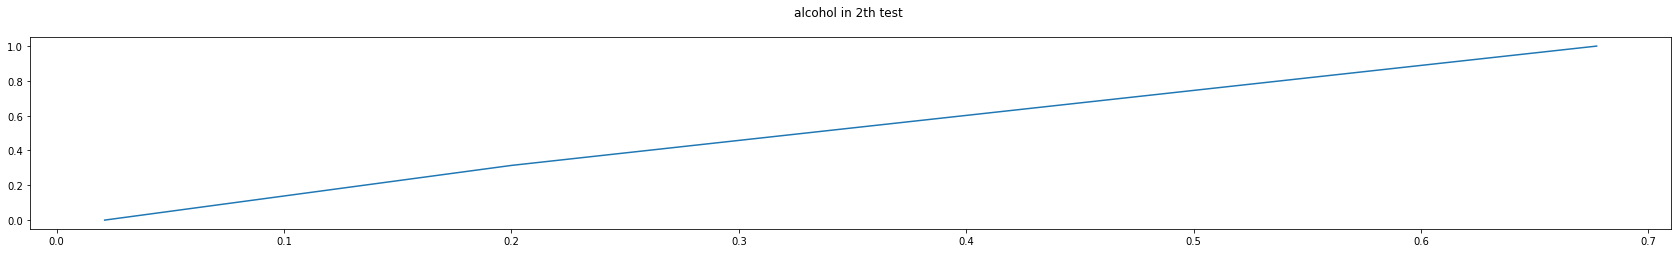

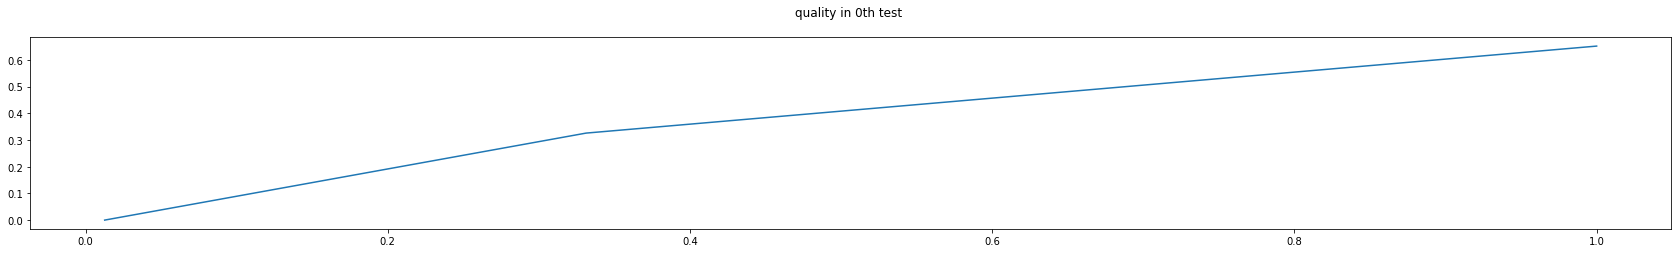

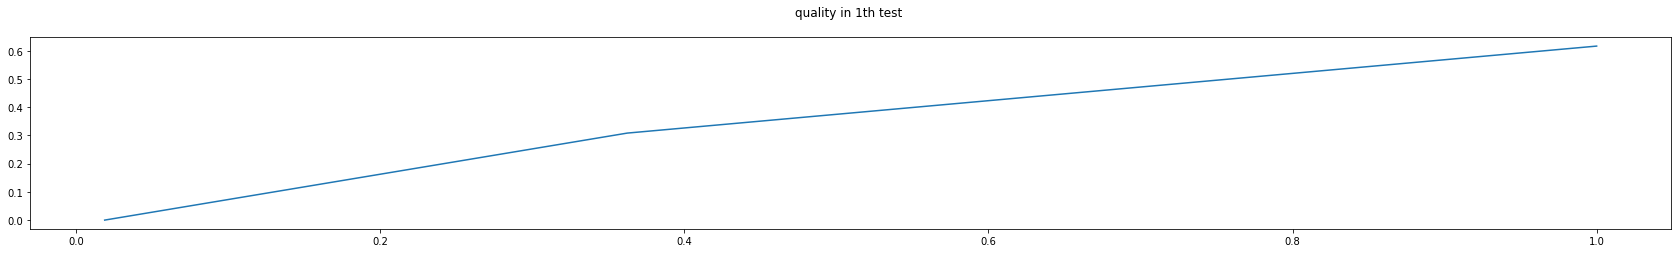

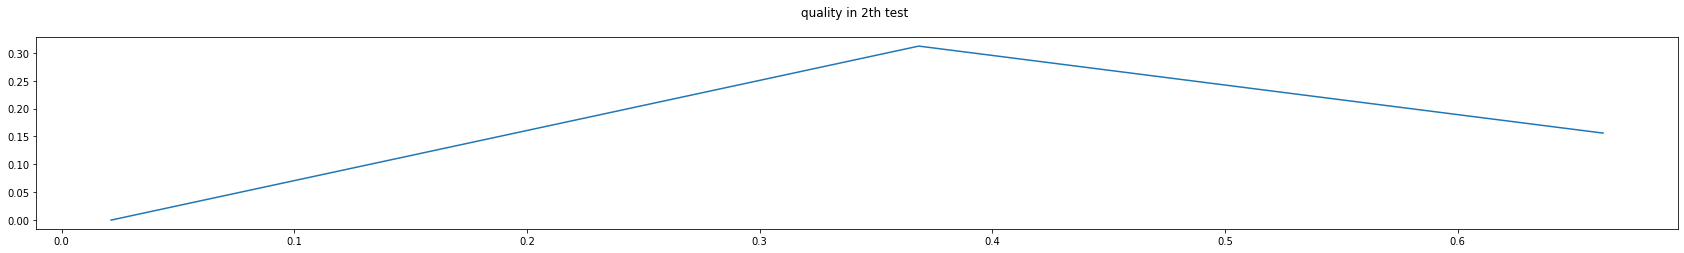

In [33]:
#ROC Curve for 3 cluster
for n in range(len(lb_3_lst)):
  Khoi_ROC(TP_lst_3[n], FP_lst_3[n], n, lb_3_lst[n])

## **K mean for white wine**

### **K mean with 2 cluster**

THE CONFUSION MATRIX OF fixed acidity in 0th test: 
     0  1
0  248  6
1  232  4

The centroids of fixed acidity in 0th test: 
[[ 1.59391688e-01  9.06663571e-02  7.72828286e-03  5.88324366e-02
   6.91231267e-02  6.58674781e-02 -1.21894590e-01]
 [ 5.13501350e-01  9.28217822e-01  8.30975955e+00  2.38699957e-01
   1.58619403e-01 -4.09067223e-01 -4.95049505e-01]]

The Accuracy is: 0.5142857142857142 
The True positive rate is: 0.4966635526491392 
The False Positive Rate is: 0.5033364473508608 
The False Negative Rate is:0.5033364473508608 
The Precision is 0.45833333333333337

The Mean Performance of fixed acidity in 0th test is: 0.49041744517104857
THE CONFUSION MATRIX OF fixed acidity in 1th test: 
   0    1
0  6  263
1  8  213

The centroids of fixed acidity in 1th test: 
[[ 0.53636364  1.0122807   8.61804511  0.31487414  0.17106616 -0.43545706
  -0.54736842]
 [ 0.15650359  0.10462555  0.01252029  0.05411345  0.06677593  0.07048133
  -0.11871087]]

The Accuracy is: 0.44693877551020406 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 0th test: 
     0    1
0   79   65
1  102  244

The centroids of quality in 0th test: 
[[ 0.33004484  0.1342234   0.54582399  1.05821589  0.35993858  0.61654775
  -0.42784301]
 [-0.13649009  0.19013304 -0.18654726 -0.38692291 -0.13895977 -0.29961407
   0.38324976]]

The Accuracy is: 0.6591836734693878 
The True positive rate is: 0.6269067116249197 
The False Positive Rate is: 0.37309328837508027 
The False Negative Rate is:0.37309328837508027 
The Precision is 0.6130540506713869

The Mean Performance of quality in 0th test is: 0.4965368347616168
THE CONFUSION MATRIX OF quality in 1th test: 
   0    1
0  8  157
1  6  319

The centroids of quality in 1th test: 
[[-0.11595745  0.53433269  1.03102837  8.66261398  0.32377428  0.1651579
  -0.43505039]
 [ 0.0622624   0.1566359   0.10442745  0.01354394  0.05397996  0.06692884
   0.07035519]]

The Accuracy is: 0.6673469387755102 
The True positive rate is: 0.515011655011655 
The False Positive Rate is: 0.48498

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 2th test: 
     0  1
0  163  6
1  315  6

The centroids of quality in 2th test: 
[[ 0.05519601  0.15849518  0.09810176  0.01040528  0.05418898  0.06410732
   0.06770685]
 [-0.09484536  0.56138707  0.91065292  8.52503682  0.25885253  0.18673277
  -0.46500271]]

The Accuracy is: 0.3448979591836735 
The True positive rate is: 0.49159431510258256 
The False Positive Rate is: 0.5084056848974174 
The False Negative Rate is:0.5084056848974174 
The Precision is 0.42050209205020916

The Mean Performance of quality in 2th test is: 0.48222694423690665


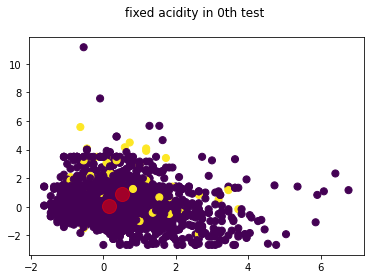

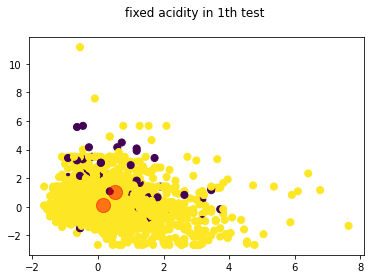

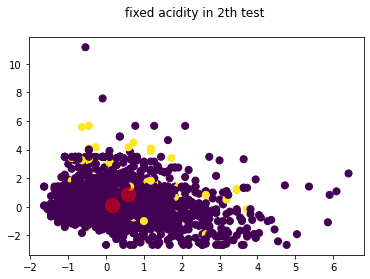

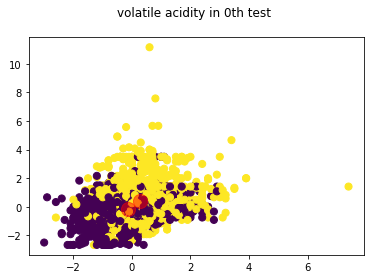

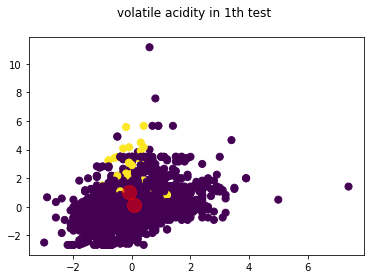

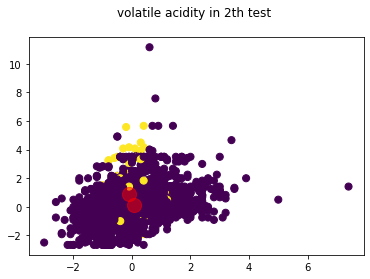

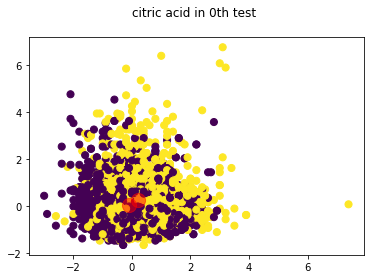

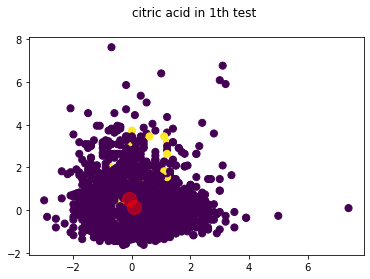

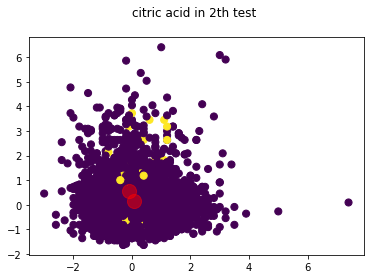

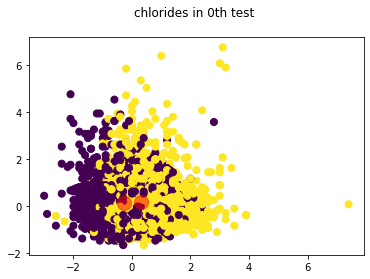

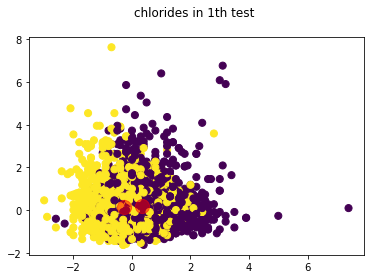

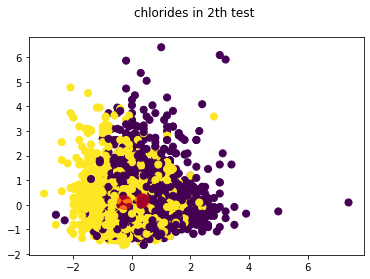

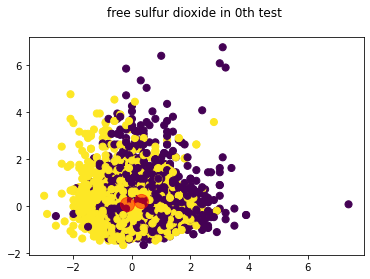

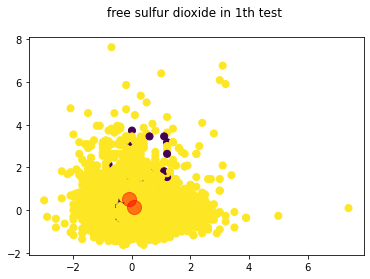

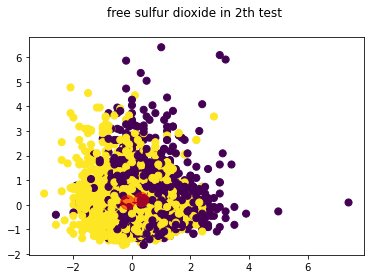

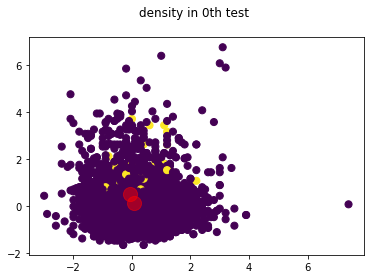

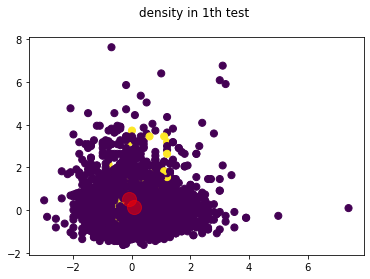

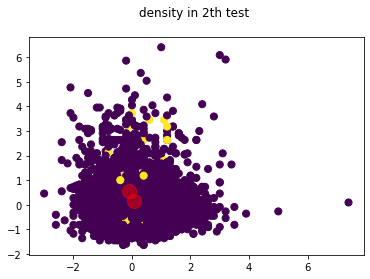

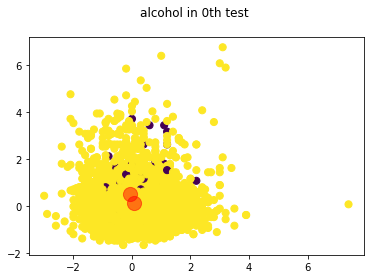

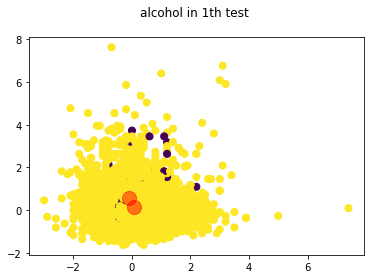

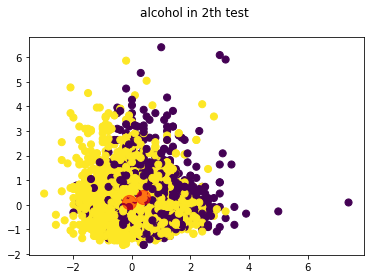

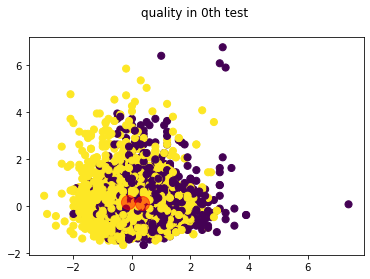

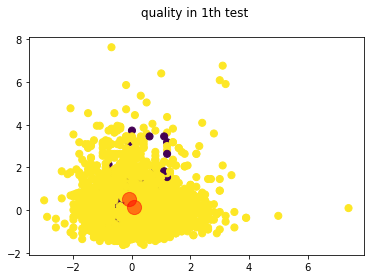

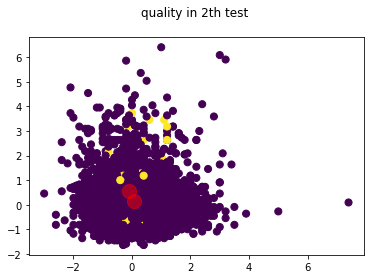

In [34]:
len_target = len(all_label_target)
k = 0
index = 0
lb_2_lst = []
TP_lst = []
FP_lst = []
while index < len_target:
  # Get needed data
  [train, test, y_actual] = needed_data(white_df, all_label_target[index], index)
  #Train
  pred = []
  centroids = []
  j = 0
  while j < len(train):
    #Train
    model_kmeans = KMeans(n_clusters=2, random_state=0).fit(train[j])
    centroids.append(model_kmeans.cluster_centers_)
    #Test
    pred.append(model_kmeans.predict(test[j]))
    #Confusion Matrix
    y_actual[j][y_actual[j] > np.mean(y_actual[j])] = 1
    y_actual[j][y_actual[j] <= np.mean(y_actual[j])] = 0
    cmatrix = confusion_matrix(y_actual[j].astype(np.int16), pred[j])
    cm_table = pd.DataFrame(cmatrix)
    cal = re_cm(cmatrix)
    print("THE CONFUSION MATRIX OF {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, cm_table))
    print("The centroids of {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, centroids[j]))
    print("The Accuracy is: {0} \nThe True positive rate is: {1} \nThe False Positive Rate is: {2} \nThe False Negative Rate is:{3} \nThe Precision is {4}\n".format(np.mean(cal[0]), np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])))
    print("The Mean Performance of {0} in {1}th test is: {2}".format(all_label_target[index], j, mean([np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])])))    
    Khoi_PLOT(train[j], centroids[j], model_kmeans.labels_, k, "{0} in {1}th test \n".format(all_label_target[index], j))
    #Store
    lb_2_lst.append("{0} in {1}th test \n".format(all_label_target[index], j))
    TP_lst.append(cal[1])
    FP_lst.append(cal[2])
    k += 1
    j += 1
  index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

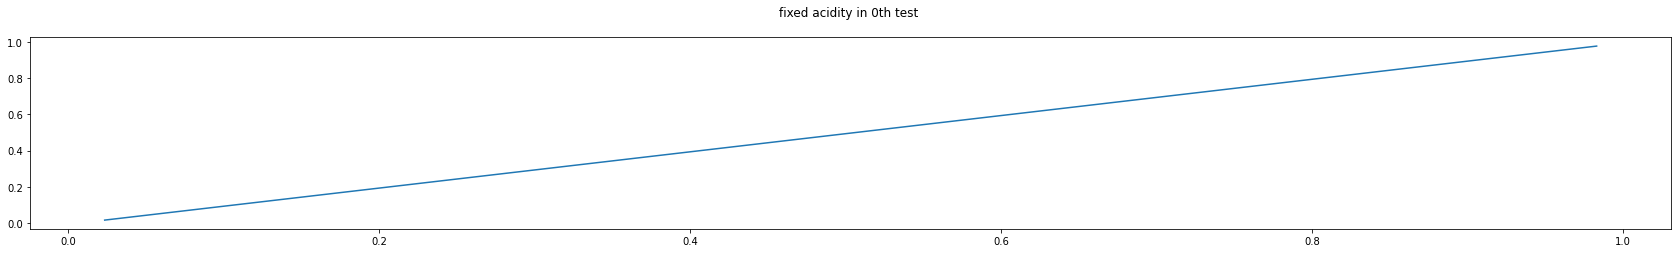

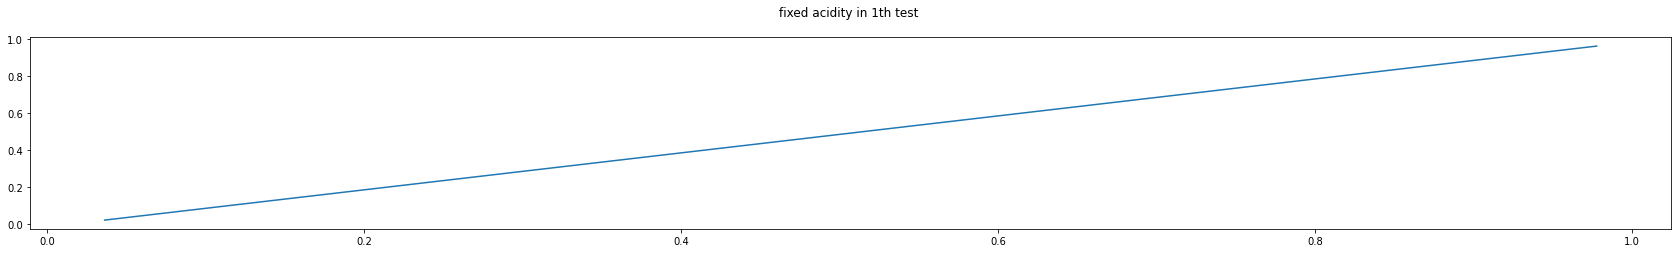

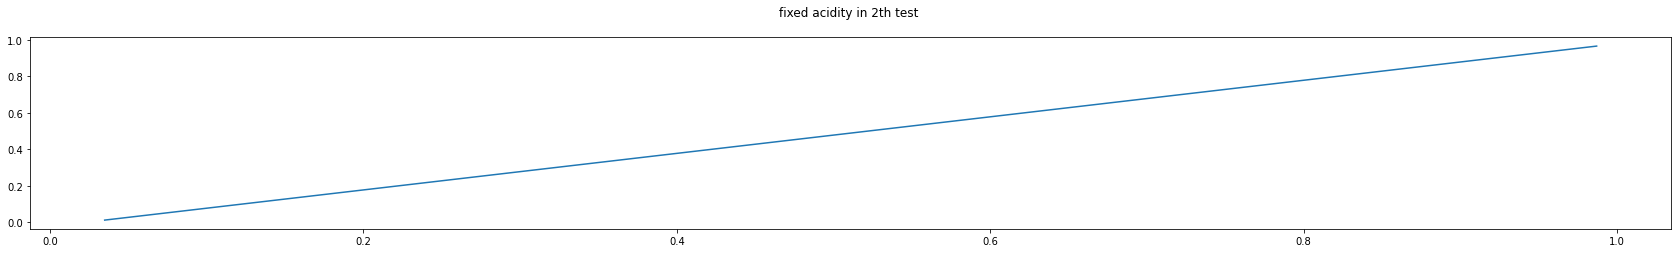

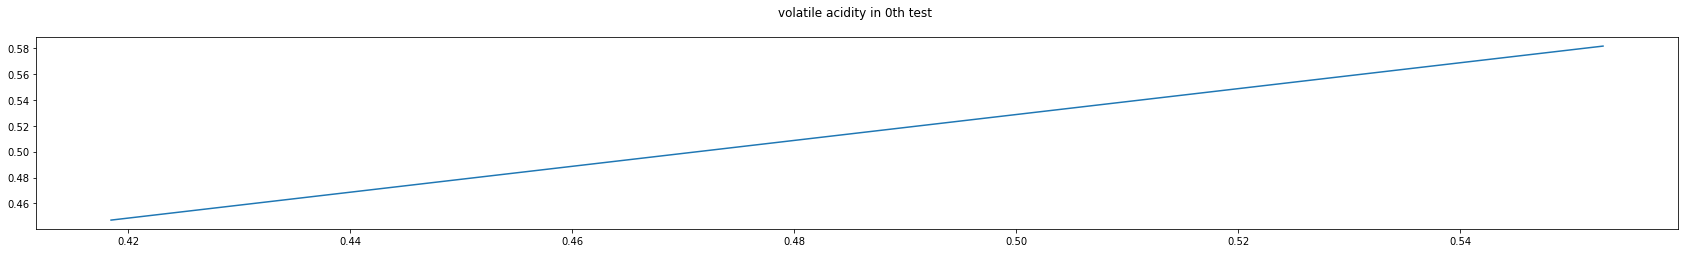

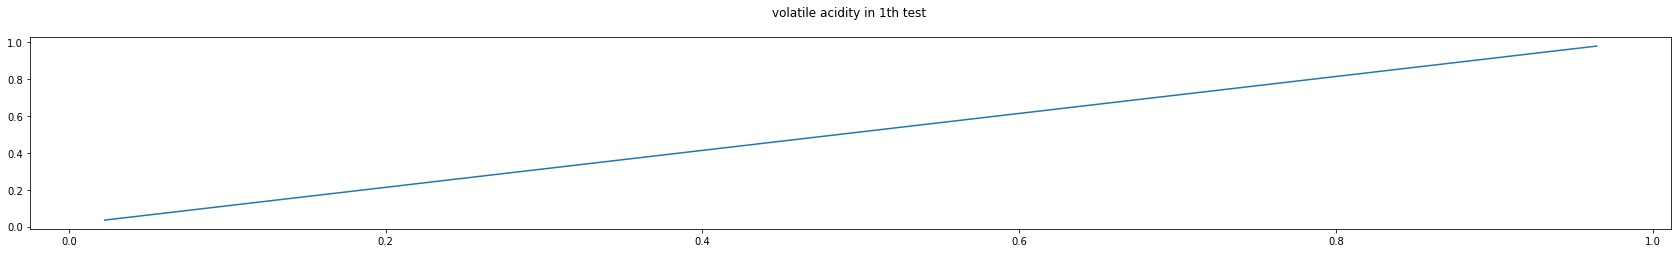

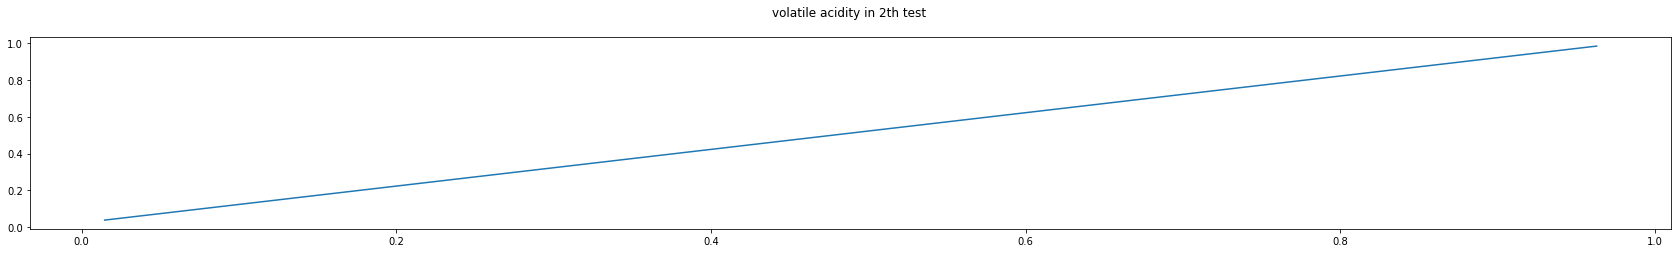

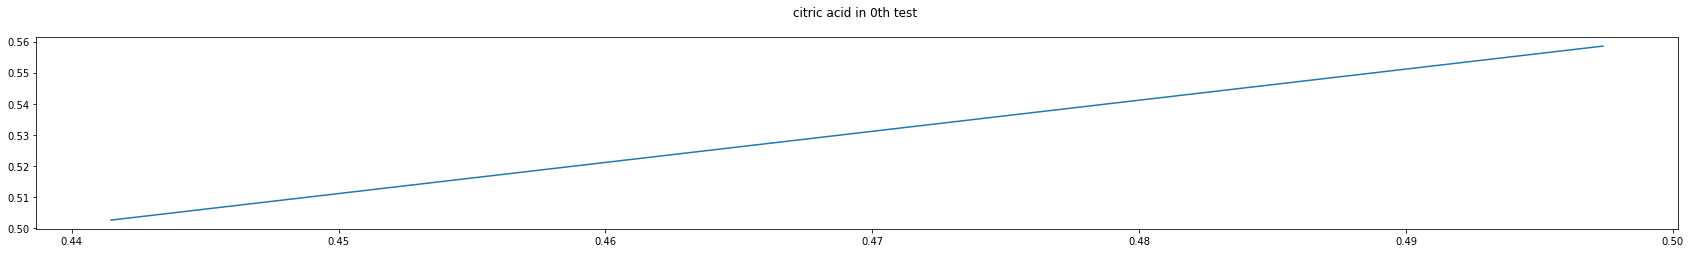

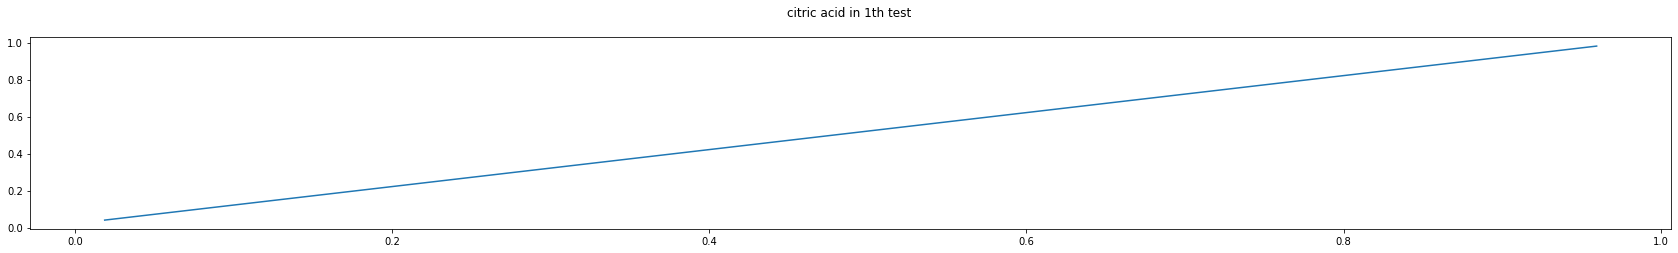

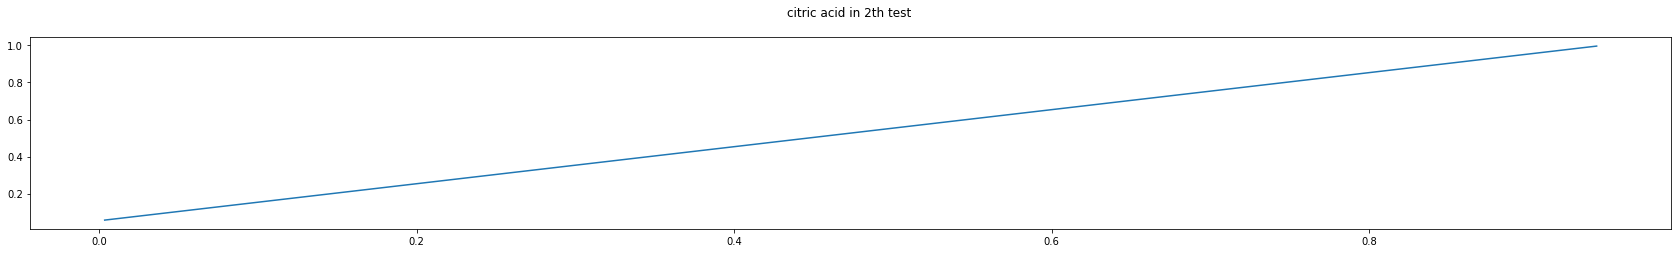

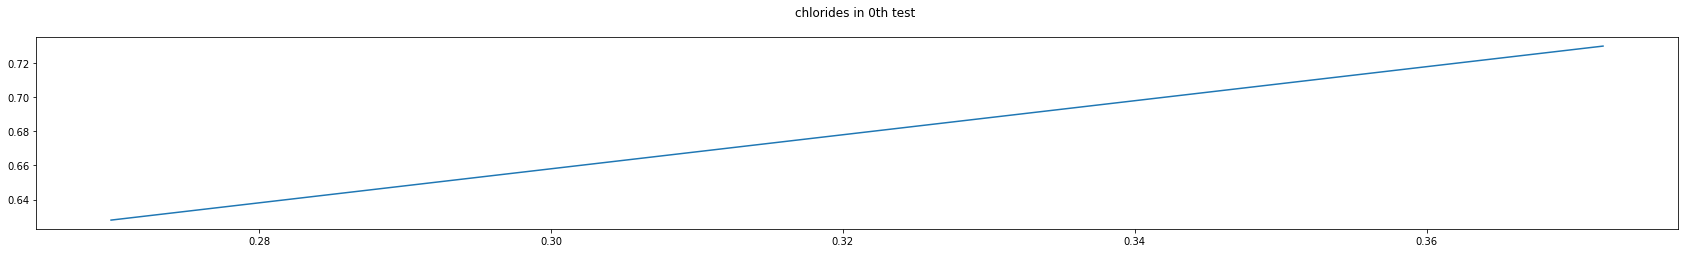

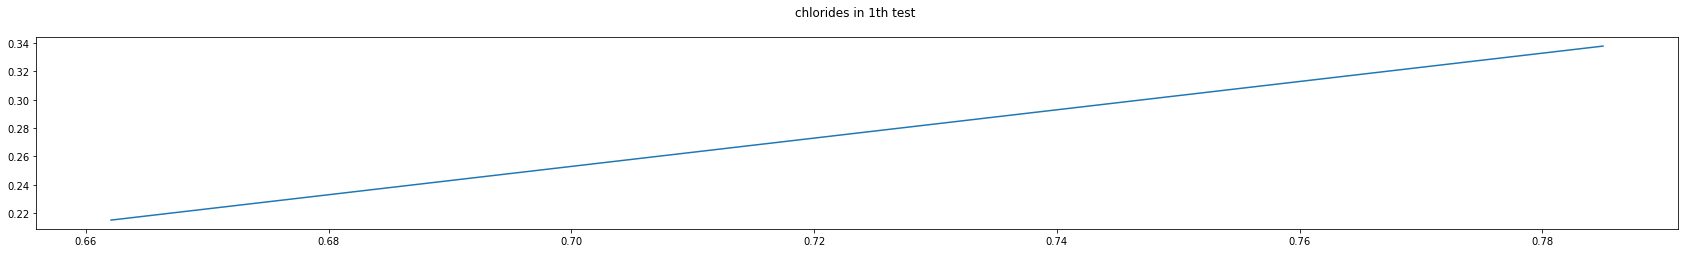

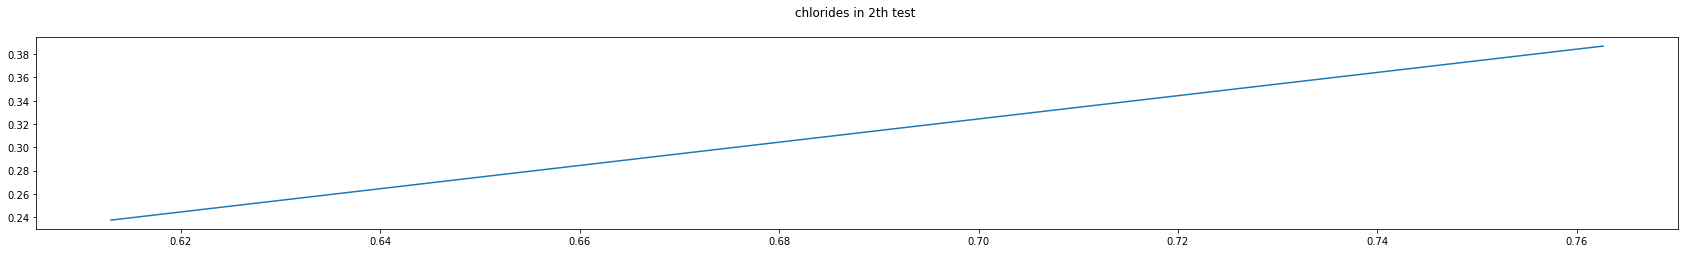

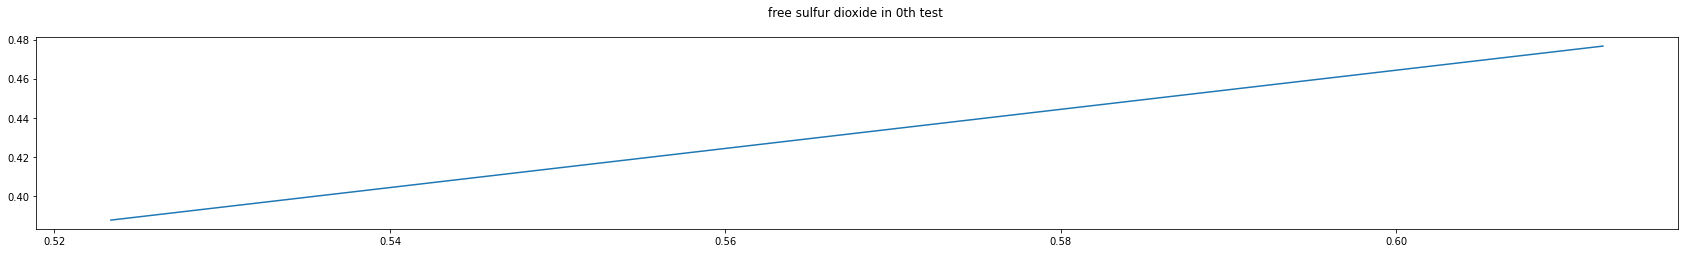

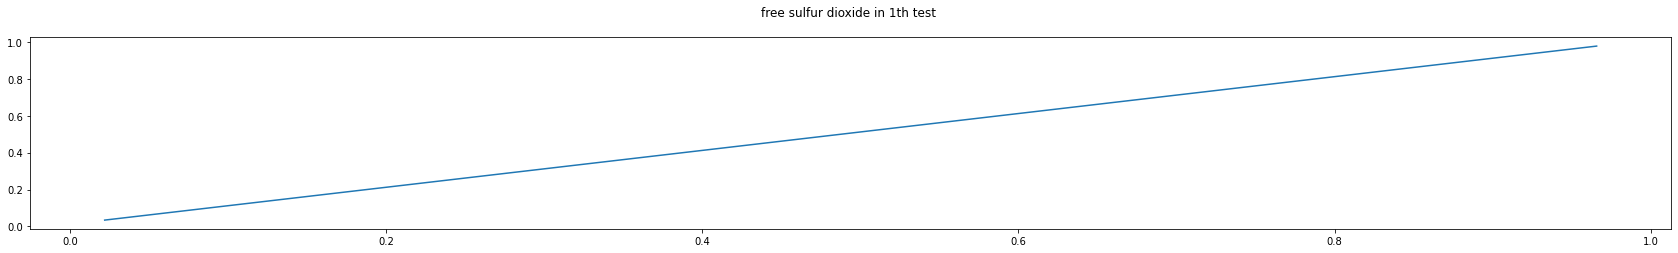

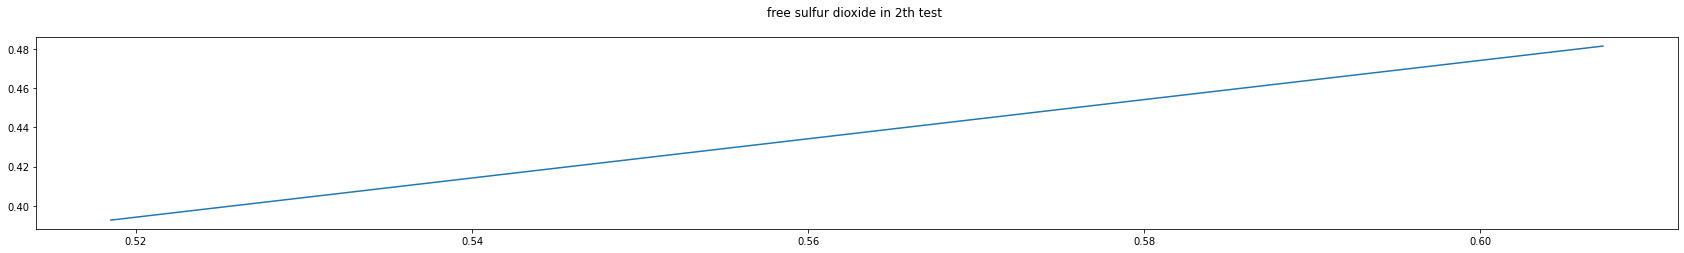

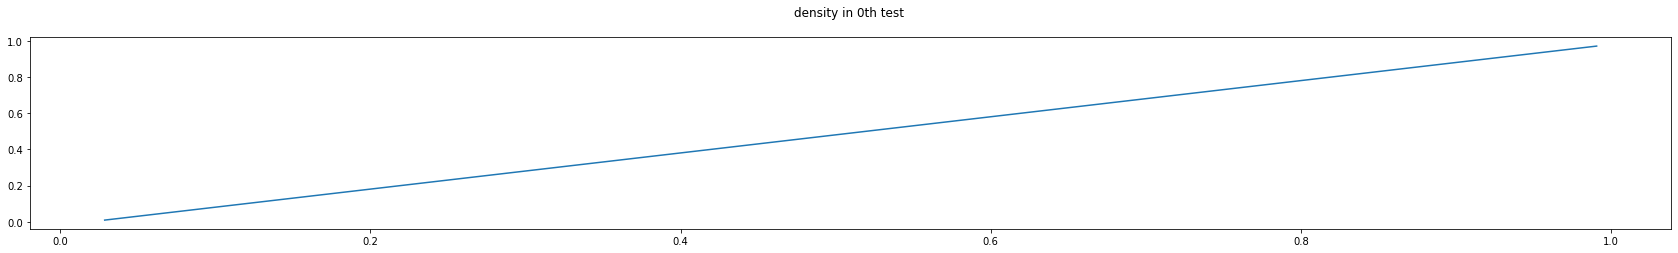

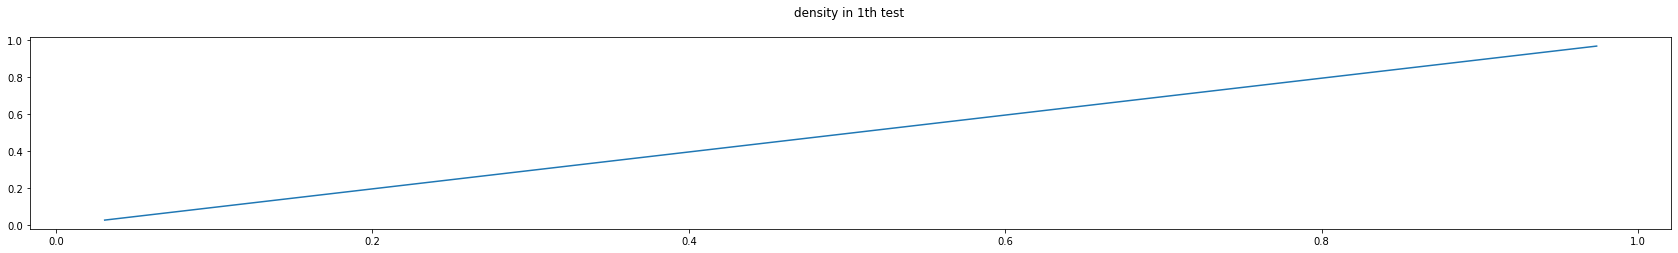

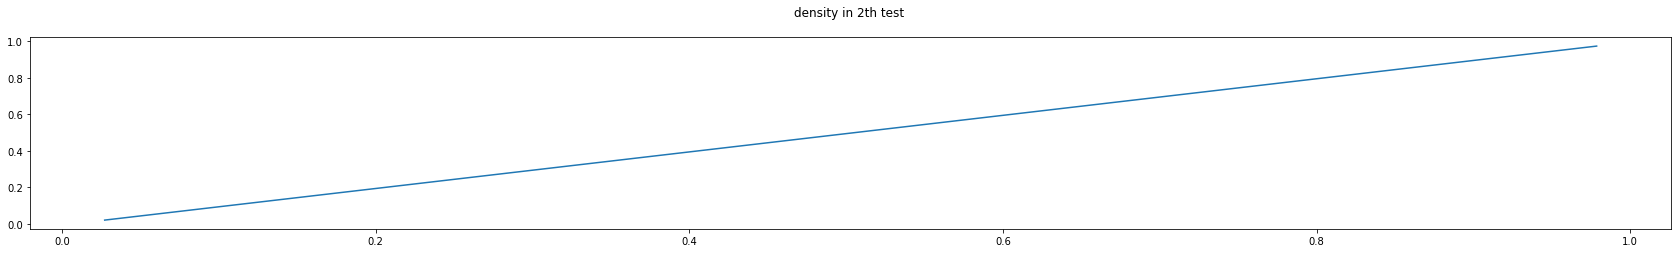

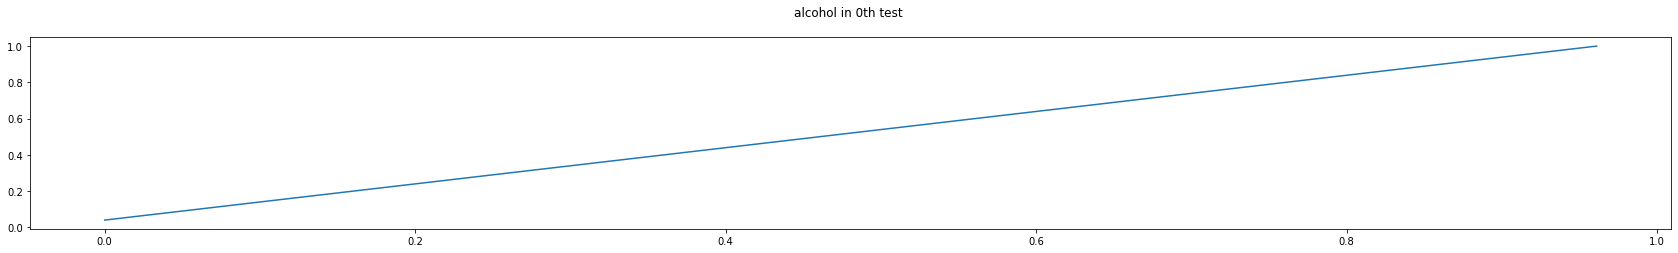

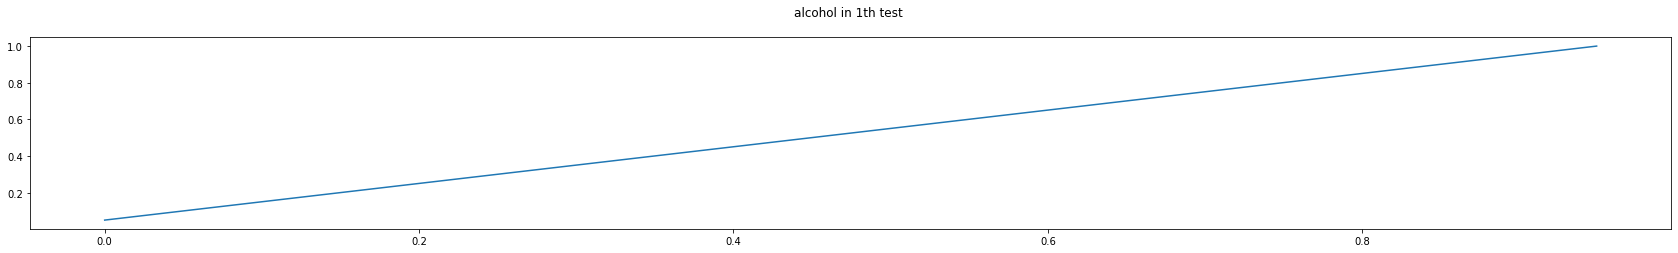

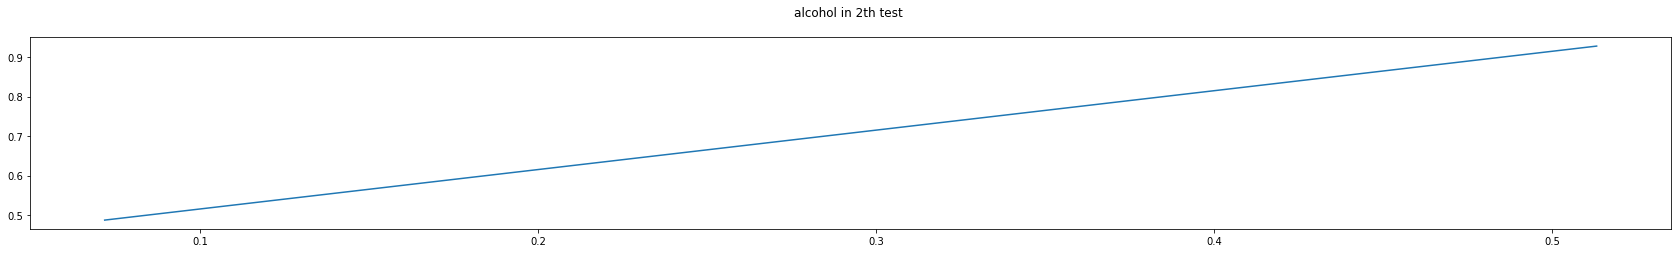

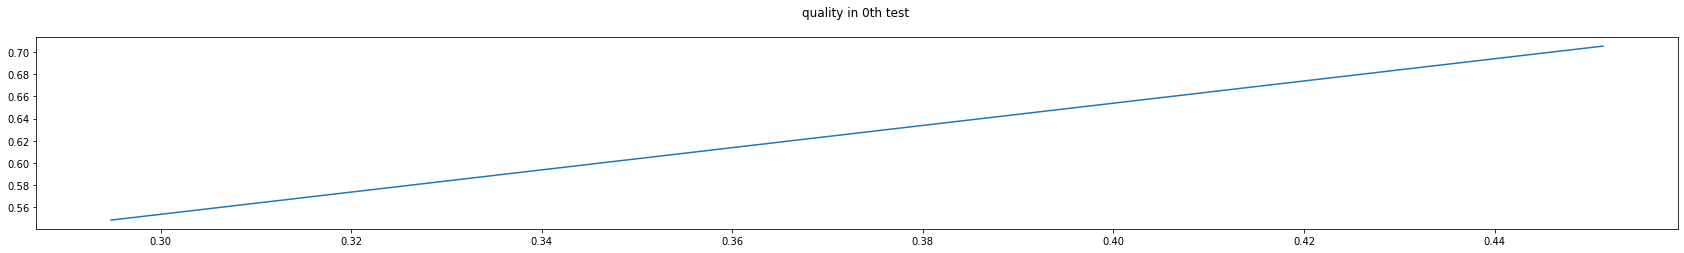

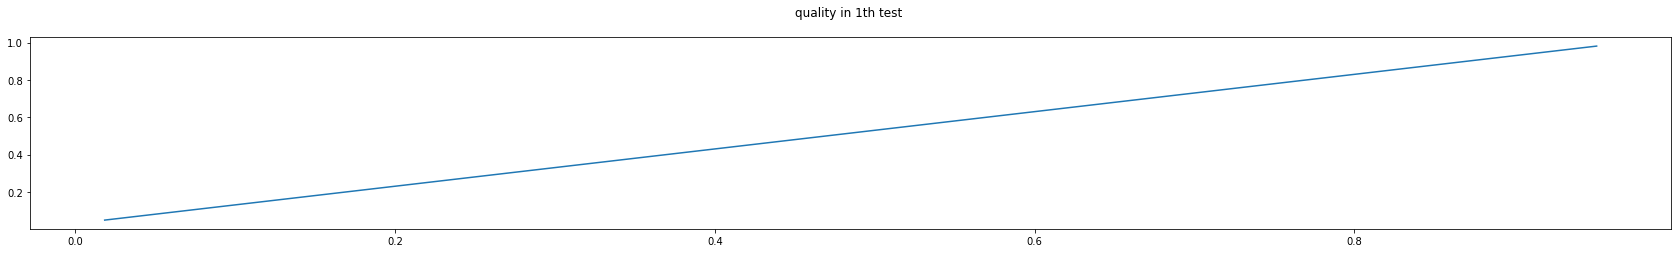

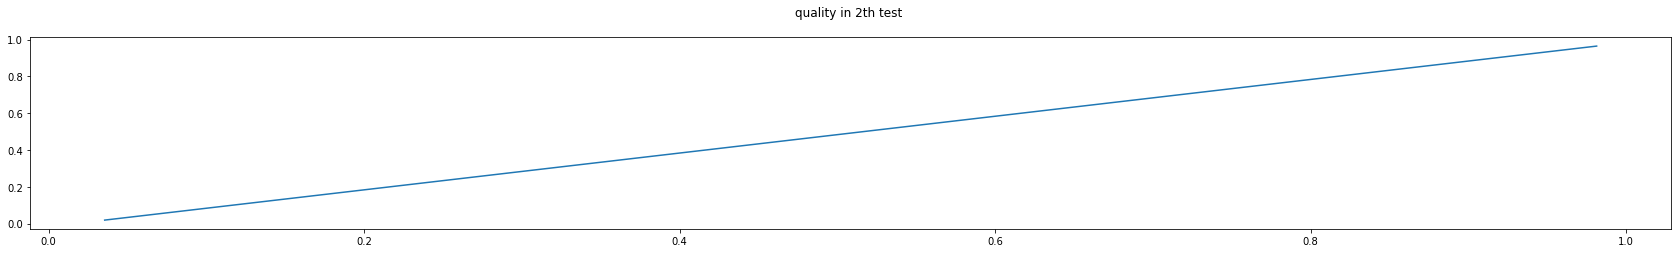

In [35]:
#ROC Curve for 2 cluster
for n in range(len(lb_2_lst)):
  Khoi_ROC(TP_lst[n], FP_lst[n], n, lb_2_lst[n])

### **K mean with 3 cluster**

THE CONFUSION MATRIX OF fixed acidity in 0th test: 
     0    1   2
0  228  244  10
1    4    3   0
2    0    1   0

The centroids of fixed acidity in 0th test: 
[[ 0.0914047   0.01237452 -0.53697523 -0.16185832 -0.46752931  0.60854694
   0.39356179]
 [ 0.21505622  0.15562544  0.45471698  0.23644153  0.50222227 -0.37215124
  -0.53920335]
 [ 0.50937207  0.92010309  8.47717231  0.26109368  0.16902271 -0.43407488
  -0.48453608]]

The Accuracy is: 0.6476190476190476 
The True positive rate is: 0.3005334914048607 
The False Positive Rate is: 0.3425654248540351 
The False Negative Rate is:0.6994665085951394 
The Precision is 0.33161846496106784

The Mean Performance of fixed acidity in 0th test is: 0.4185459724537758


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF fixed acidity in 1th test: 
    0    1    2
0  13  252  213
1   0    9    3
2   0    0    0

The centroids of fixed acidity in 1th test: 
[[ 0.51926877  1.01992754  8.75698758  0.32041588  0.15454523 -0.4319222
  -0.5326087 ]
 [ 0.20791246  0.16785915  0.46416546  0.23479359  0.50125373 -0.36895342
  -0.53114478]
 [ 0.09493908  0.02822165 -0.53391016 -0.16703272 -0.46440267  0.60772563
   0.38505155]]

The Accuracy is: 0.36326530612244895 
The True positive rate is: 0.38859832635983266 
The False Positive Rate is: 0.3226709930834259 
The False Negative Rate is:0.6114016736401673 
The Precision is 0.3448275862068966

The Mean Performance of fixed acidity in 1th test is: 0.41687464482258063
THE CONFUSION MATRIX OF fixed acidity in 2th test: 
     0    1   2
0  258  213  12
1    5    2   0
2    0    0   0

The centroids of fixed acidity in 2th test: 
[[ 0.21818564  0.15446128  0.46479678  0.23557129  0.49703296 -0.37131623
  -0.53367003]
 [ 0.08802569  0.02905278 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF citric acid in 2th test: 
     0   1    2
0  258  10  212
1    6   2    1
2    1   0    0

The centroids of citric acid in 2th test: 
[[ 0.23504482  0.22380899  0.42301199  0.20476773  0.47977521 -0.35057407
  -0.53545232]
 [-0.09473684  0.54736842  8.61578947  0.26384439  0.17801557 -0.46315789
  -0.52631579]
 [-0.182383    0.07342657 -0.52973949 -0.14461959 -0.48402373  0.61919727
   0.44755245]]

The Accuracy is: 0.6870748299319728 
The True positive rate is: 0.2532407407407407 
The False Positive Rate is: 0.3854576142919701 
The False Negative Rate is:0.7467592592592593 
The Precision is 0.380083857442348

The Mean Performance of citric acid in 2th test is: 0.4413853679335795
THE CONFUSION MATRIX OF chlorides in 0th test: 
     0    1    2
0  102  211  172
1    2    0    2
2    1    0    0

The centroids of chlorides in 0th test: 
[[-0.20168291  0.76189709 -0.68098612  0.06440867  0.31496111 -0.30000311
  -0.83082374]
 [-0.25779456  0.03065092 -0.08222558 -0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF density in 0th test: 
     0   1    2
0  218  10  226
1   34   0    2
2    0   0    0

The centroids of density in 0th test: 
[[ 0.3052105   0.19915495  0.29133667  0.41719764  0.2046233  -0.31245548
  -0.57857441]
 [-0.09278351  0.50937207  0.92010309  8.47717231  0.26109368 -0.43407488
  -0.48453608]
 [-0.25760983  0.11045074 -0.15895223 -0.49716079 -0.12485219  0.54082709
   0.44979079]]

The Accuracy is: 0.6299319727891156 
The True positive rate is: 0.24008810572687225 
The False Positive Rate is: 0.4772589995371619 
The False Negative Rate is:0.7599118942731278 
The Precision is 0.28835978835978837

The Mean Performance of density in 0th test is: 0.44140469697423756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF density in 1th test: 
    0    1    2
0  13  233  208
1   0    2   34
2   0    0    0

The centroids of density in 1th test: 
[[-0.11630435  0.51926877  1.01992754  8.75698758  0.32041588 -0.4319222
  -0.5326087 ]
 [-0.26008167  0.13912479 -0.184618   -0.48103989 -0.1273609   0.52049202
   0.42062277]
 [ 0.33003818  0.17209858  0.3458846   0.42826838  0.20505986 -0.30432307
  -0.56809504]]

The Accuracy is: 0.3537414965986394 
The True positive rate is: 0.04209495839451786 
The False Positive Rate is: 0.33569780335041505 
The False Negative Rate is:0.9579050416054823 
The Precision is 0.33617021276595743

The Mean Performance of density in 1th test is: 0.41796700402909315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF density in 2th test: 
     0   1    2
0  235  12  215
1   26   0    2
2    0   0    0

The centroids of density in 2th test: 
[[ 0.31077117  0.19631563  0.3019349   0.42282361  0.20054484 -0.31077558
  -0.57041073]
 [-0.09473684  0.54736842  0.90175439  8.61578947  0.26384439 -0.46315789
  -0.52631579]
 [-0.26141671  0.11277539 -0.15300121 -0.49588554 -0.12706166  0.5356977
   0.45614946]]

The Accuracy is: 0.653061224489796 
The True positive rate is: 0.25432900432900435 
The False Positive Rate is: 0.4658008658008658 
The False Negative Rate is:0.7456709956709956 
The Precision is 0.3001277139208174

The Mean Performance of density in 2th test is: 0.4414821449304208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF alcohol in 0th test: 
     0    1   2
0  217  204  10
1    6   53   0
2    0    0   0

The centroids of alcohol in 0th test: 
[[ 0.39944316  0.212529    0.41047951  0.45591647  0.22600625  0.50450561
  -0.55777262]
 [-0.28810297  0.10712177 -0.22707947 -0.43238139 -0.10893765 -0.36635943
   0.31261596]
 [-0.09278351  0.50937207  0.92010309  8.47717231  0.26109368  0.16902271
  -0.48453608]]

The Accuracy is: 0.7006802721088435 
The True positive rate is: 0.7008926815840183 
The False Positive Rate is: 0.1984736479829259 
The False Negative Rate is:0.29910731841598176 
The Precision is 0.3931066171124799

The Mean Performance of alcohol in 0th test is: 0.39789506627385146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF alcohol in 1th test: 
     0    1   2
0  185  221  13
1   68    3   0
2    0    0   0

The centroids of alcohol in 1th test: 
[[-0.28104004  0.10672301 -0.22771898 -0.42005785 -0.10493407 -0.35570549
   0.31063046]
 [ 0.41021932  0.20824672  0.44256494  0.45723618  0.21551462  0.49602694
  -0.55529631]
 [-0.11630435  0.51926877  1.01992754  8.75698758  0.32041588  0.15454523
  -0.5326087 ]]

The Accuracy is: 0.5891156462585033 
The True positive rate is: 0.24189048371373825 
The False Positive Rate is: 0.5039077972780426 
The False Negative Rate is:0.7581095162862616 
The Precision is 0.2482060511951816

The Mean Performance of alcohol in 1th test is: 0.438028462118306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF alcohol in 2th test: 
     0   1    2
0  235  11  179
1    5   1   59
2    0   0    0

The centroids of alcohol in 2th test: 
[[ 0.40624706  0.21463342  0.43197119  0.45759243  0.22590724  0.50010314
  -0.55237201]
 [-0.09473684  0.54736842  0.90175439  8.61578947  0.26384439  0.17801557
  -0.52631579]
 [-0.28715659  0.10474942 -0.22622863 -0.42167059 -0.11323459 -0.36041728
   0.31776557]]

The Accuracy is: 0.654421768707483 
The True positive rate is: 0.2841628959276018 
The False Positive Rate is: 0.1961732385261797 
The False Negative Rate is:0.7158371040723982 
The Precision is 0.3541666666666667

The Mean Performance of alcohol in 2th test is: 0.3875849762982116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 0th test: 
    0    1    2
0  10  221  240
1   0    4   15
2   0    0    0

The centroids of quality in 0th test: 
[[-0.09278351  0.50937207  0.92010309  8.47717231  0.26109368  0.16902271
  -0.43407488]
 [ 0.34875118  0.07111644  0.44211436  0.47495624  0.33762242  0.55239742
  -0.35488285]
 [-0.22859753  0.24579509 -0.24813461 -0.43744698 -0.21208811 -0.39965676
   0.47397995]]

The Accuracy is: 0.3523809523809524 
The True positive rate is: 0.11587886914739076 
The False Positive Rate is: 0.32987420021086994 
The False Negative Rate is:0.8841211308526092 
The Precision is 0.3392592592592592

The Mean Performance of quality in 0th test is: 0.41728336486753226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 1th test: 
    0    1    2
0  11  232  224
1   2   19    2
2   0    0    0

The centroids of quality in 1th test: 
[[-0.11630435  0.51926877  1.01992754  8.75698758  0.32041588  0.15454523
  -0.4319222 ]
 [-0.22222725  0.24970163 -0.23928625 -0.42967083 -0.20947901 -0.39032368
   0.47235552]
 [ 0.36037019  0.06008111  0.4661446   0.48230389  0.33059574  0.54687362
  -0.35172233]]

The Accuracy is: 0.3741496598639456 
The True positive rate is: 0.4248207801880644 
The False Positive Rate is: 0.34832300670011973 
The False Negative Rate is:0.5751792198119356 
The Precision is 0.3072836857697416

The Mean Performance of quality in 1th test is: 0.41390167311746534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 2th test: 
     0    1   2
0  227  235  12
1   14    2   0
2    0    0   0

The centroids of quality in 2th test: 
[[-0.22804328  0.24971309 -0.24620529 -0.4315664  -0.21315717 -0.39152534
   0.4671104 ]
 [ 0.35491647  0.06294207  0.4638027   0.4823389   0.33720037  0.54700308
  -0.35573839]
 [-0.09473684  0.54736842  0.90175439  8.61578947  0.26384439  0.17801557
  -0.46315789]]

The Accuracy is: 0.6448979591836735 
The True positive rate is: 0.30195147679324896 
The False Positive Rate is: 0.46509012887855566 
The False Negative Rate is:0.6980485232067511 
The Precision is 0.3167825107527823

The Mean Performance of quality in 2th test is: 0.4454681599078345


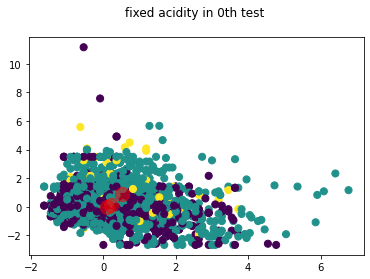

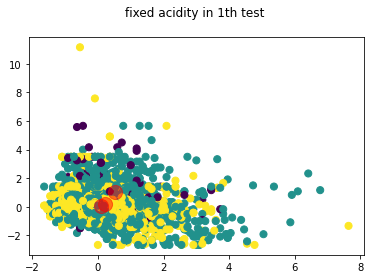

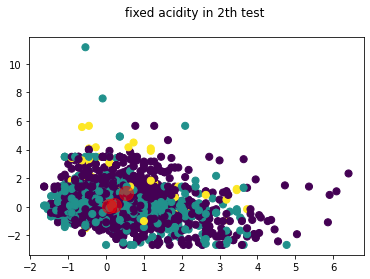

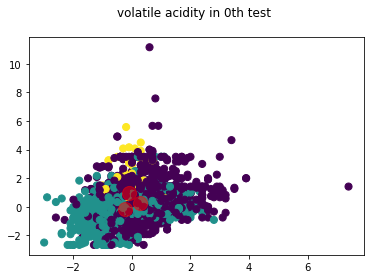

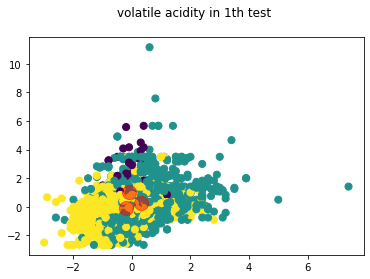

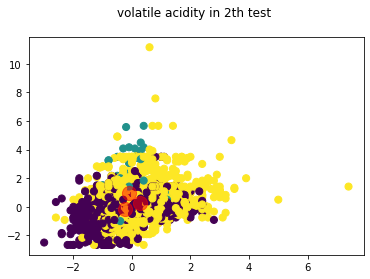

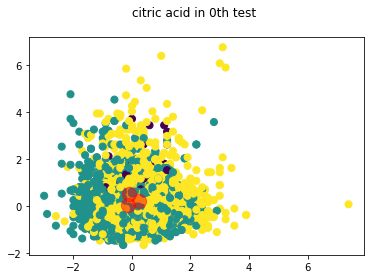

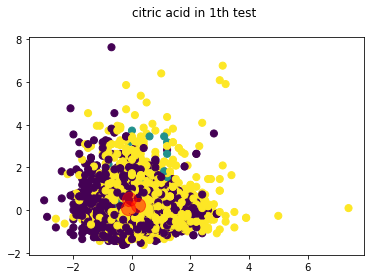

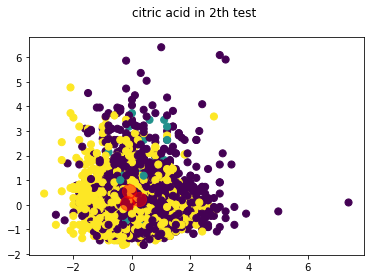

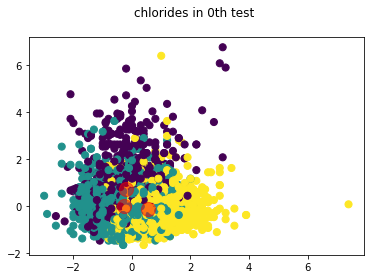

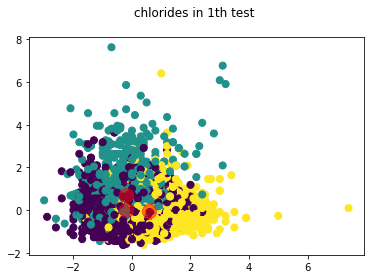

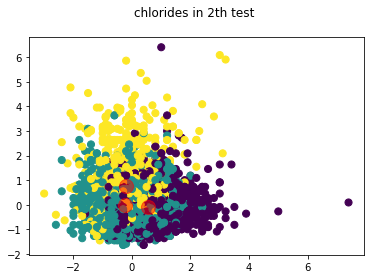

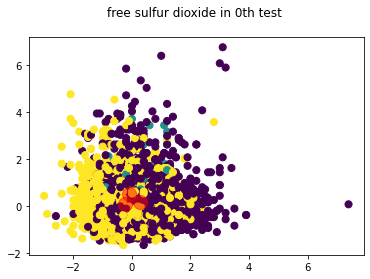

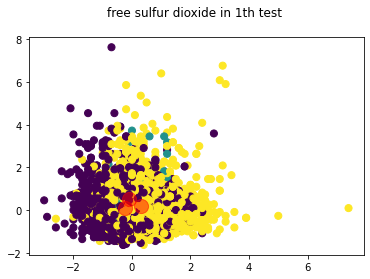

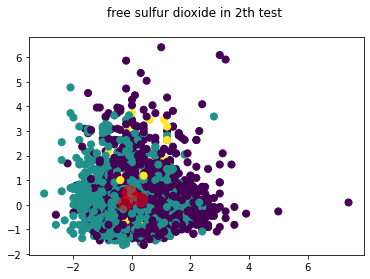

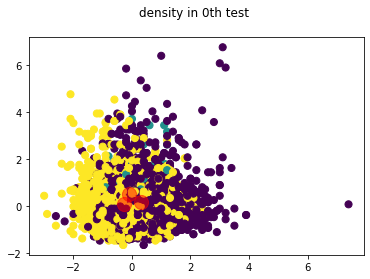

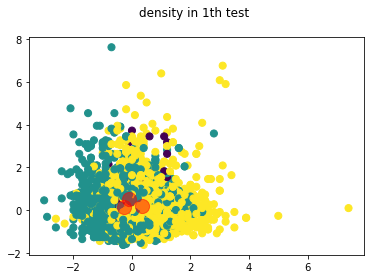

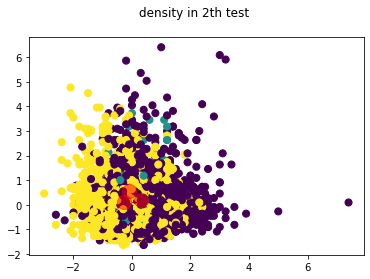

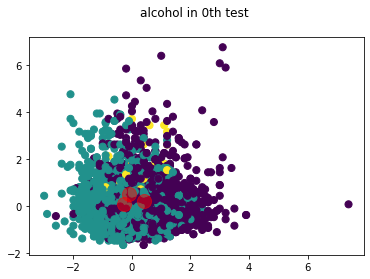

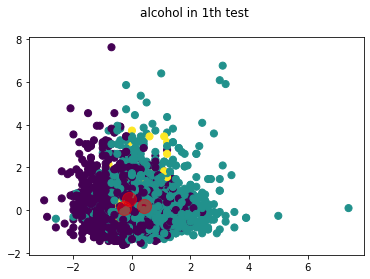

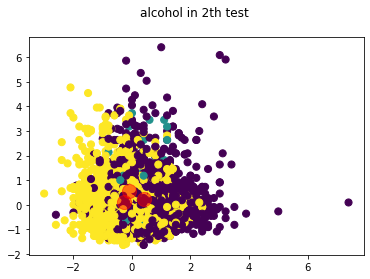

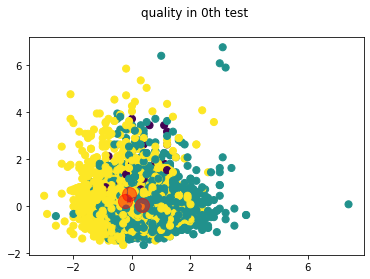

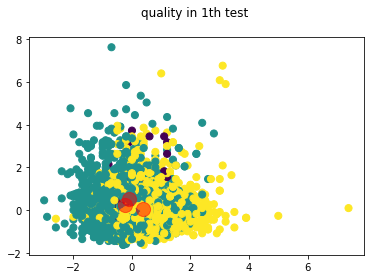

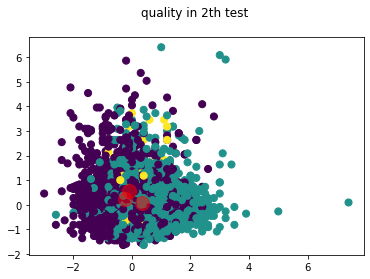

In [36]:
len_target = len(all_label_target)
k = 0
index = 0
lb_3_lst = []
TP_lst_3 = []
FP_lst_3 = []
while index < len_target:
  # Get needed data
  [train, test, y_actual] = needed_data(white_df, all_label_target[index], index)
  #Train
  pred = []
  centroids = []
  j = 0
  while j < len(train):
    #Train
    model_kmeans = KMeans(n_clusters=3, random_state=0).fit(train[j])
    centroids.append(model_kmeans.cluster_centers_)
    #Test
    pred.append(model_kmeans.predict(test[j]))
    #Confusion Matrix
    dis = np.amax(y_actual[j]) - np.amin(y_actual[j])
    y_actual[j][y_actual[j] < (dis/3)] = 0
    y_actual[j][(y_actual[j] >= (dis/3)) & (y_actual[j] < (dis/3)*2)] = 1
    y_actual[j][y_actual[j] >= (dis/3)*2] = 2
    cmatrix = confusion_matrix(y_actual[j].astype(np.int16), pred[j])
    cm_table = pd.DataFrame(cmatrix)
    cal = re_cm(cmatrix)
    print("THE CONFUSION MATRIX OF {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, cm_table))
    print("The centroids of {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, centroids[j]))
    print("The Accuracy is: {0} \nThe True positive rate is: {1} \nThe False Positive Rate is: {2} \nThe False Negative Rate is:{3} \nThe Precision is {4}\n".format(np.mean(cal[0]), np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])))
    print("The Mean Performance of {0} in {1}th test is: {2}".format(all_label_target[index], j, mean([np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])])))    
    Khoi_PLOT(train[j], centroids[j], model_kmeans.labels_, k, "{0} in {1}th test \n".format(all_label_target[index], j))
    #Store
    lb_3_lst.append("{0} in {1}th test \n".format(all_label_target[index], j))
    TP_lst_3.append(cal[1])
    FP_lst_3.append(cal[2])
    k += 1
    j += 1
  index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

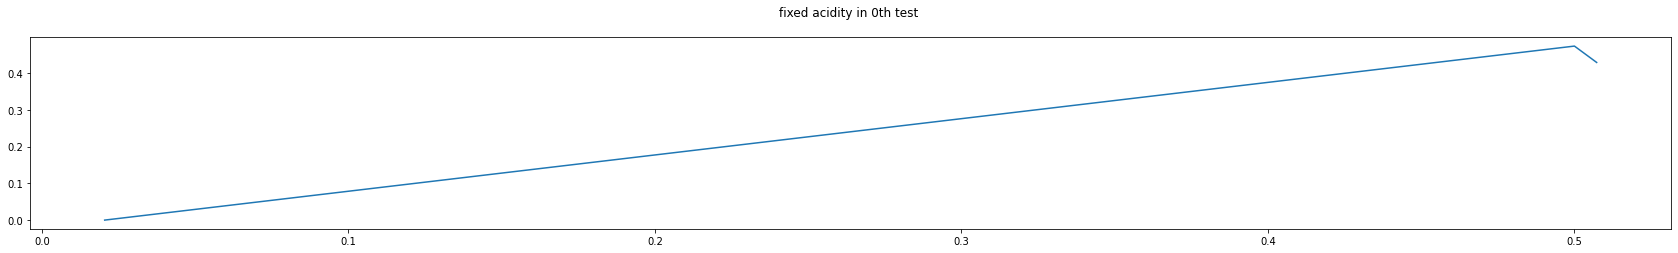

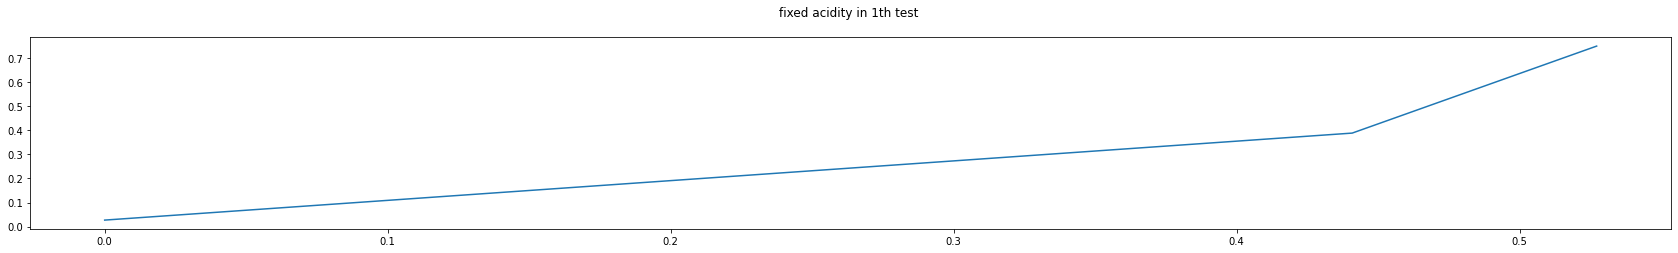

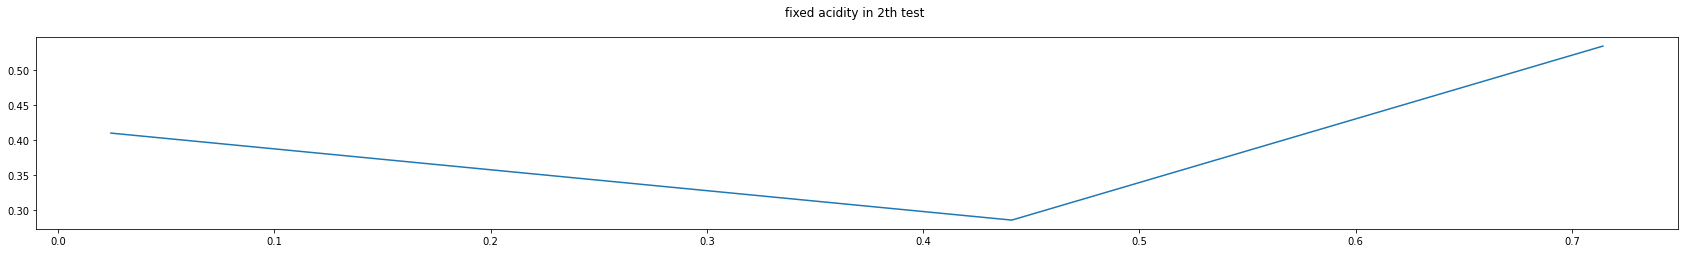

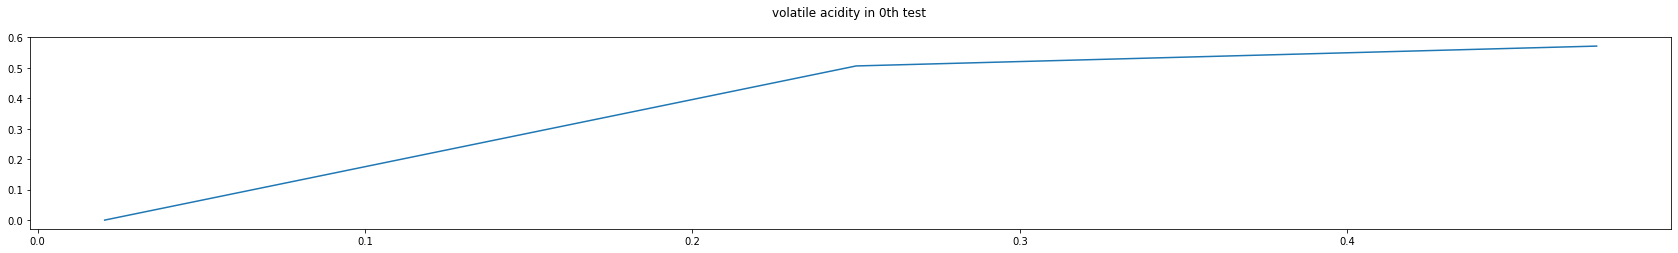

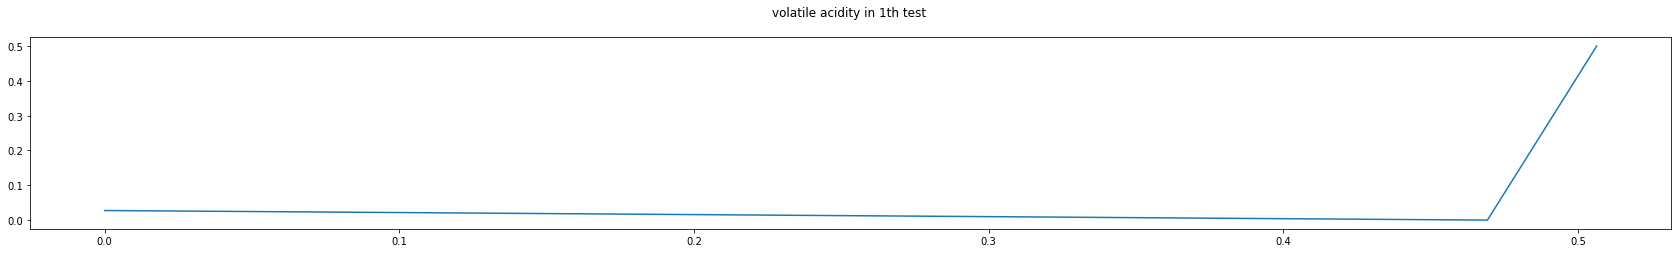

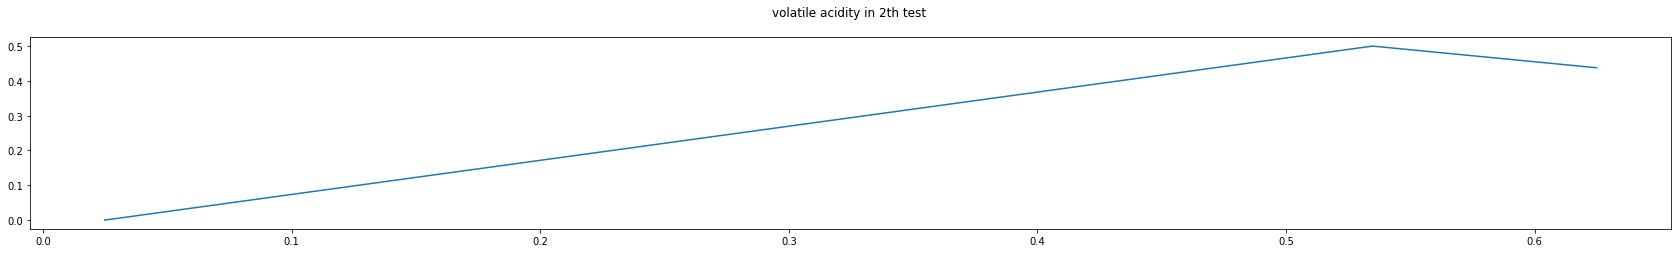

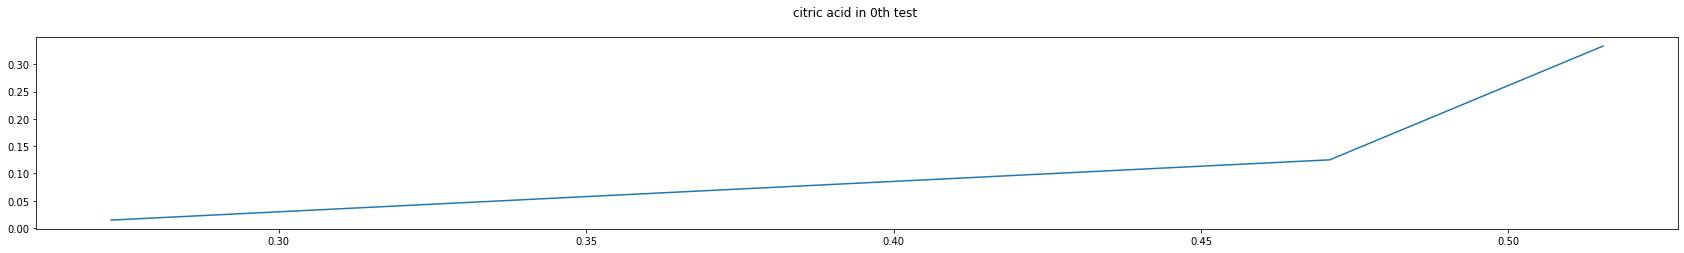

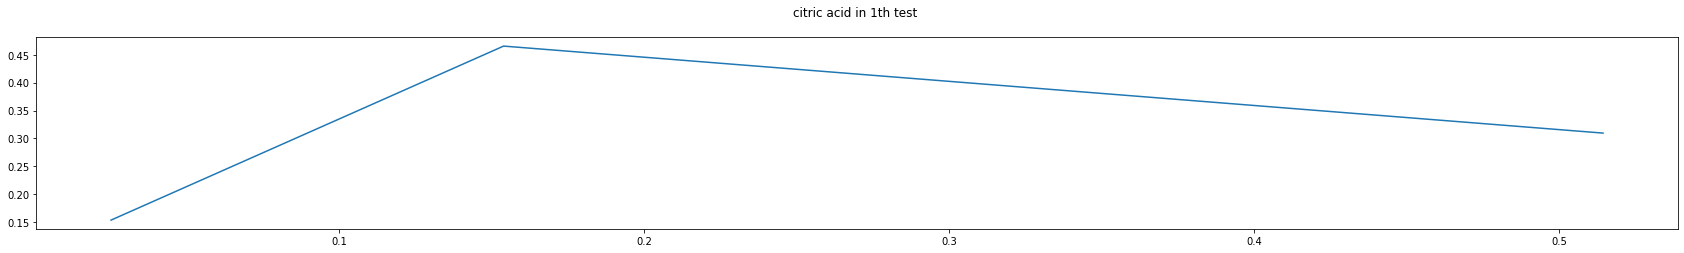

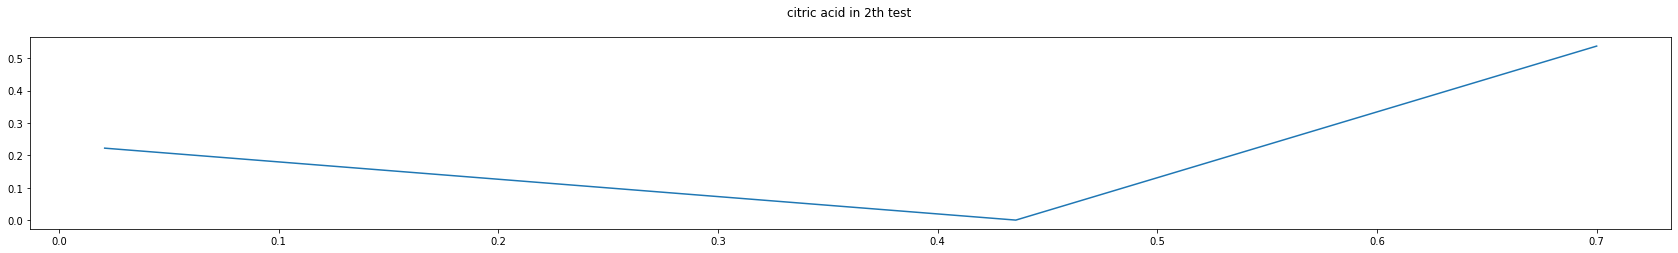

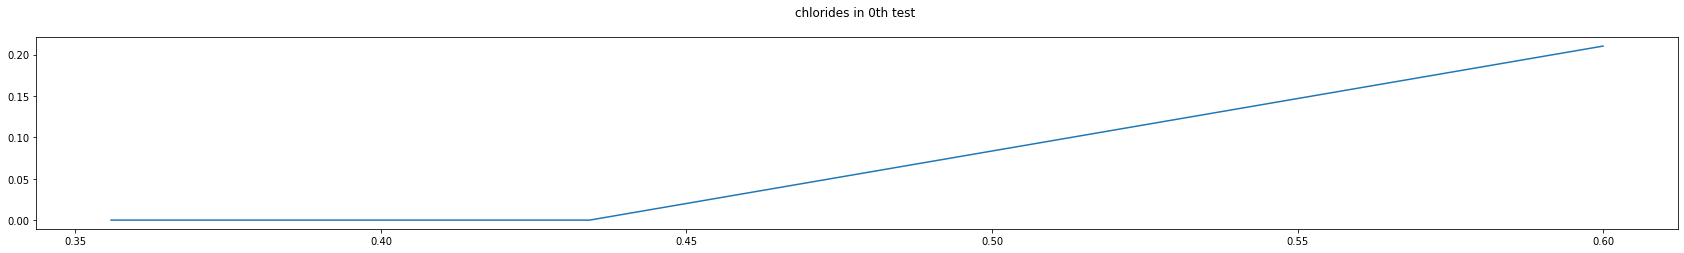

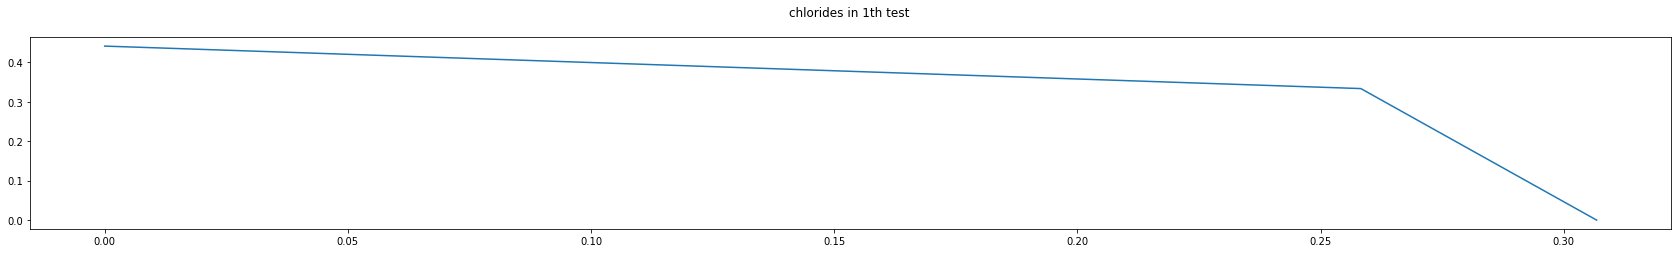

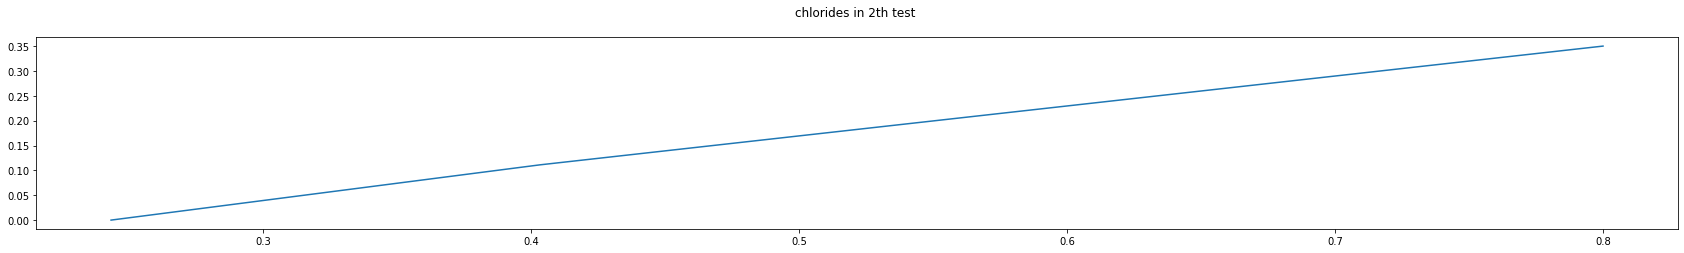

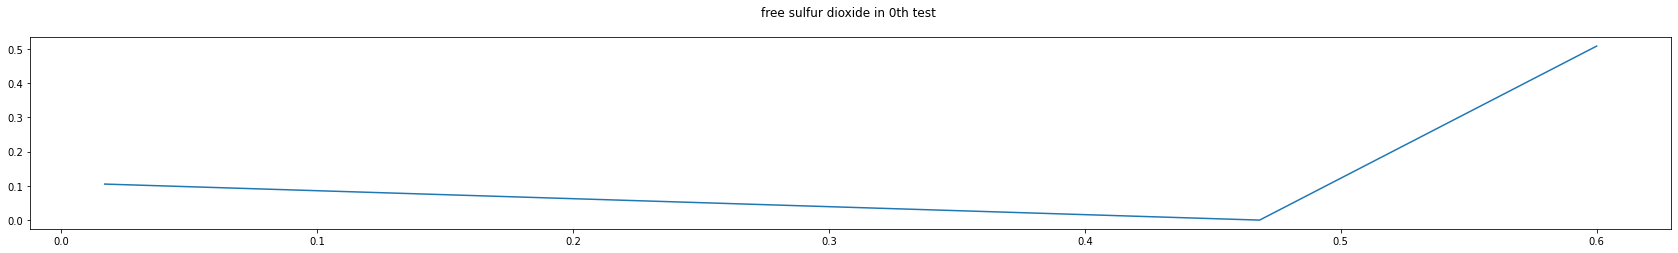

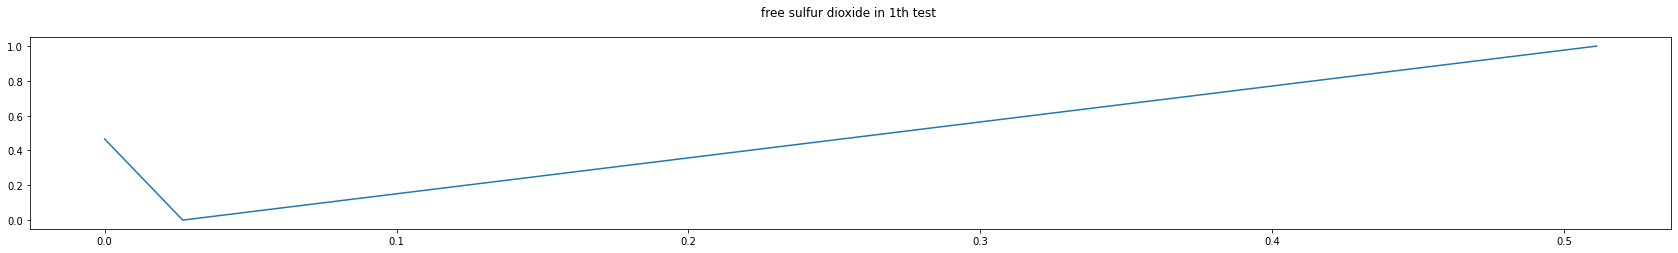

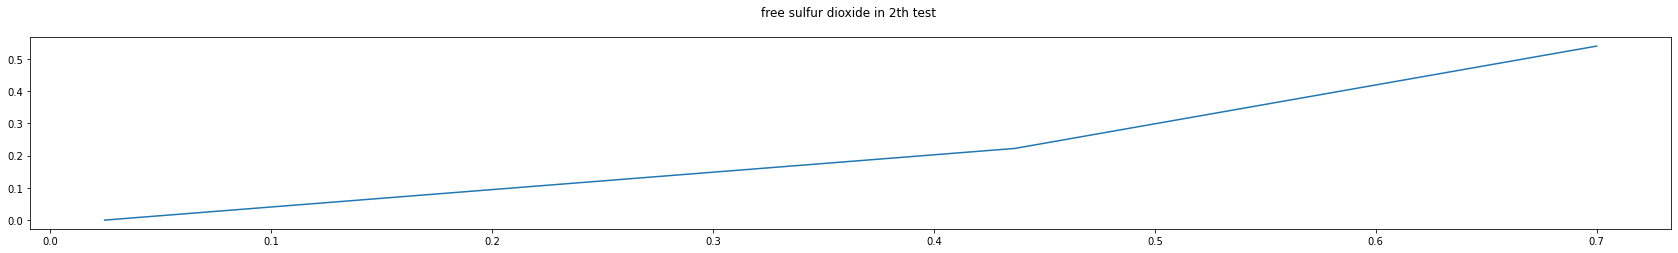

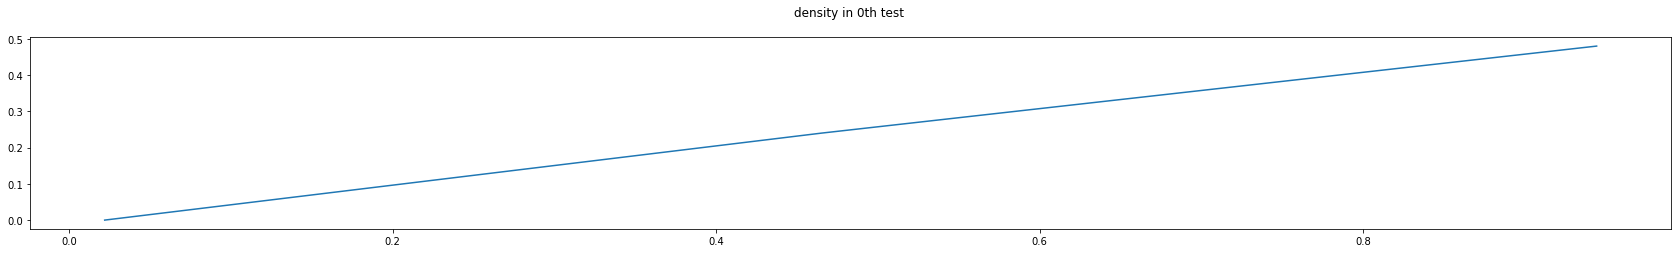

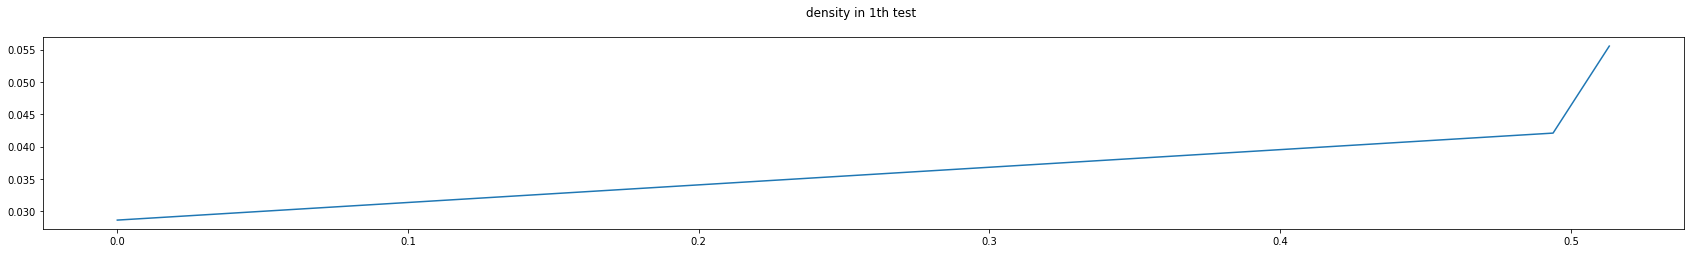

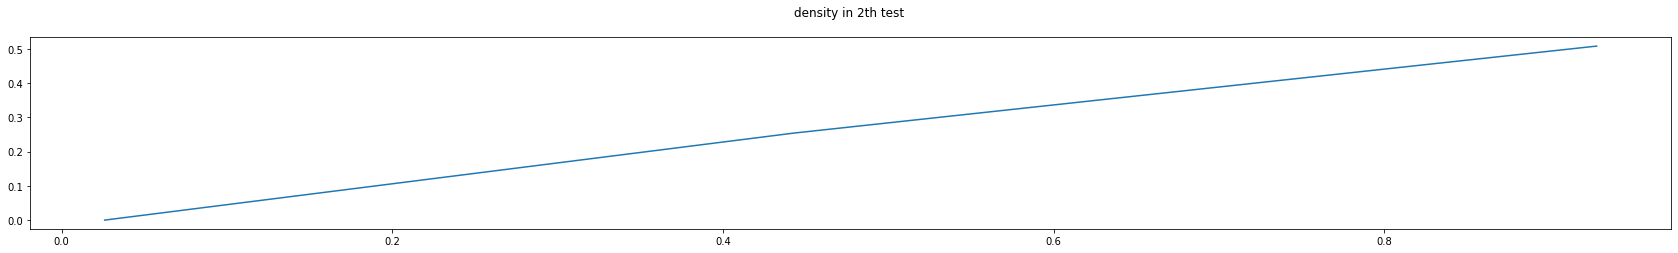

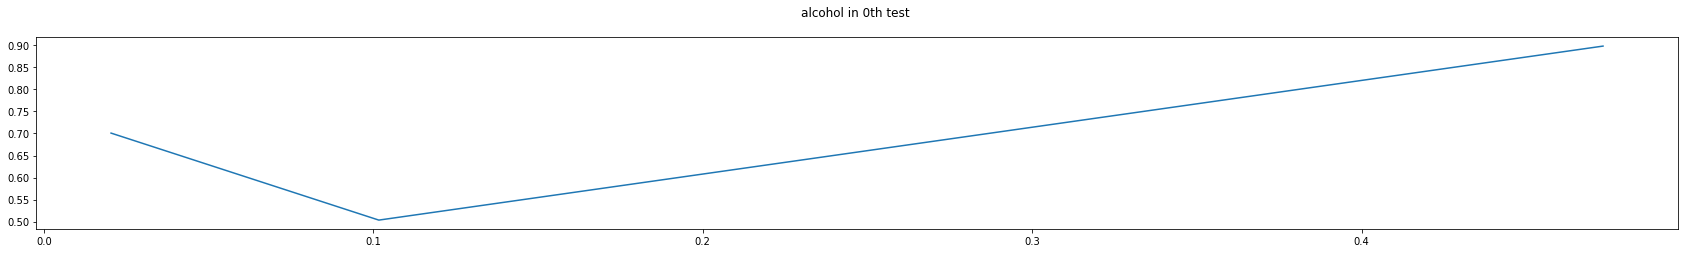

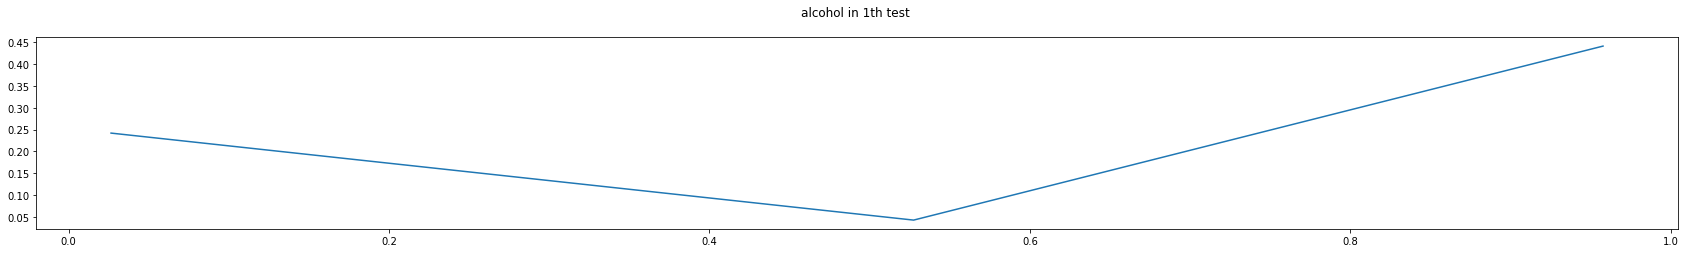

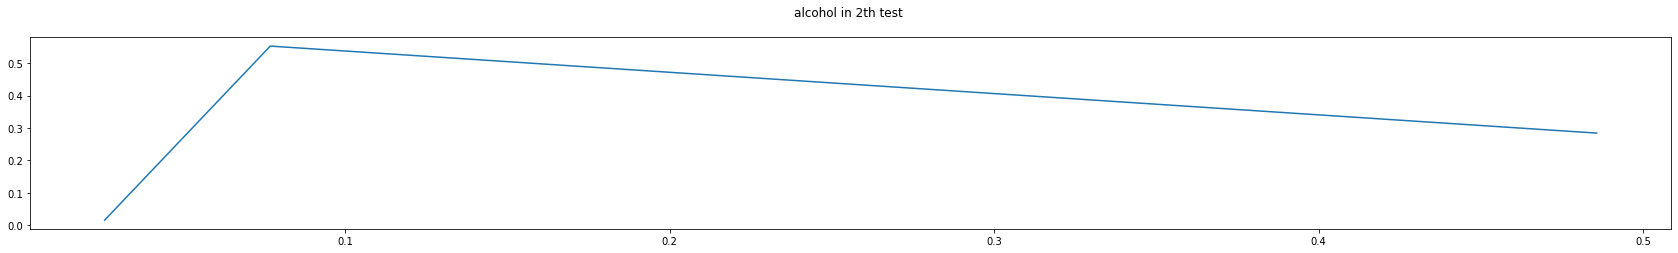

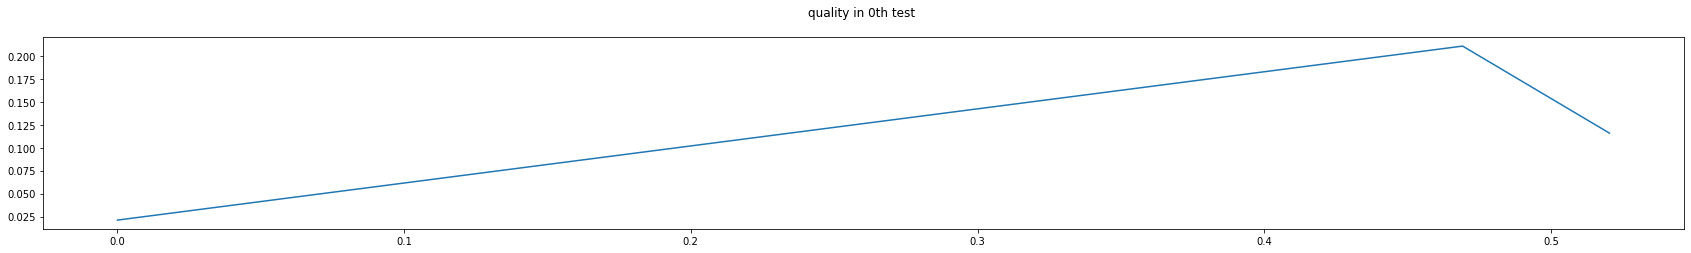

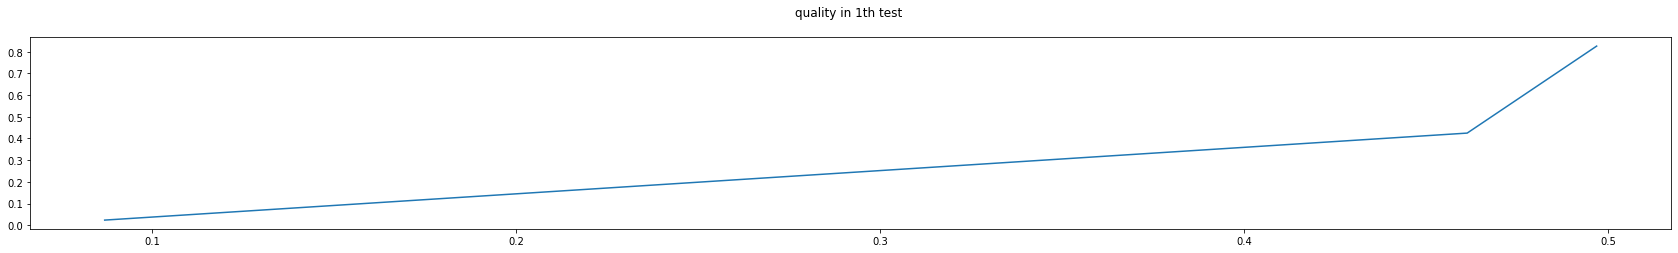

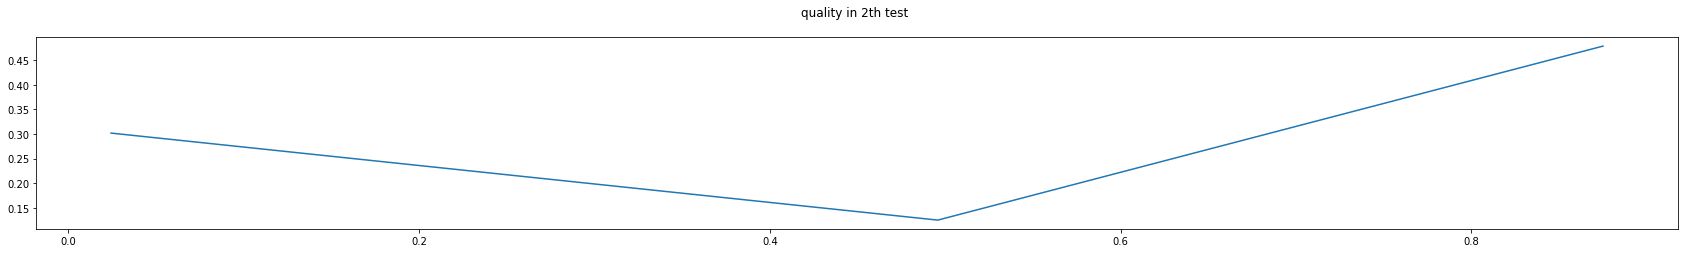

In [37]:
#ROC Curve for 3 cluster
for n in range(len(lb_3_lst)):
  Khoi_ROC(TP_lst_3[n], FP_lst_3[n], n, lb_3_lst[n])